# Mesh Deformation using differentiable rendering and 3D Loss:

This project implements an ML algorithm to deform a source mesh to fit a target mesh. The renderer also estimates the texture of the mesh


Mesh vertices are modified to match the silhouette of the *** rendered from various perspectives. It will also solve for the texture simultaneously. Mesh deformation is optimised for both silhouette and texture prediction.

The following loss functions are utilised to quantify error and optimise the model:


## Imports

In [ ]:
#Building wheels for packages pytorch3d and iopath takes around 30 minutes
import os
import sys
import torch
from google.colab import drive
from google.colab import files

need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.1.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [ ]:
!pip install trimesh
!pip install fast-simplification

In [ ]:
import warnings
from math import log

import numpy as np
import torch
from tqdm.notebook import trange
import matplotlib.pyplot as plt
import trimesh

import pytorch3d
from pytorch3d.io import load_objs_as_meshes, save_obj
from pytorch3d.loss import (
    mesh_edge_loss,
    mesh_laplacian_smoothing,
    mesh_normal_consistency,
)
from pytorch3d.ops import SubdivideMeshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    AmbientLights,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    SoftSilhouetteShader,
    TexturesVertex
)
from pytorch3d.structures.meshes import Meshes

from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

%matplotlib inline

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Helper functions:

In [ ]:
def upsample_mesh(src_mesh: pytorch3d.structures.meshes.Meshes,
                  texture_colour: list[float, float, float] = None) -> pytorch3d.structures.meshes.Meshes:
  """
  Upsamples the given source mesh using subdivision.

  this function increases the number of vertices in a triangle mesh by
  "adding a new vertex at the center of each edge and dividing each face into four new faces" [PyTorch3D Docs]
  If a colour is defined, the resulting mesh will be assigned a uniform colour texture so that it
  is compatible with PyTorch3D Mesh Renderers

  Args:
    src_mesh: the PyTorch3D mesh to be upsampled
    texture_colour: the RGB colour (values ranging from 0 to 1) to be applied to the resulting mesh

  Returns:
    An upsampled version of the input mesh

  Raises: None
  """
  subdivider = SubdivideMeshes()

  # Subdivide the mesh
  subdivided_src_mesh = subdivider(src_mesh)
  print(f"Subdivided number of vertices: {subdivided_src_mesh.verts_list()[0].shape[0]}")

  # subdividing more than once leads to CUDA out of memory
  # subdivided_src_mesh = src_mesh
  # for _ in range(2):
  #     subdivided_src_mesh = subdivider(subdivided_src_mesh)

  if texture_colour is not None:
    # the subdivider removes the texture - which is required for rendering
    # so add a uniform colout texture
    subdivided_verts = subdivided_src_mesh.verts_packed()
    num_subdivided_verts = subdivided_verts.shape[0]
    uniform_color = torch.tensor([[texture_colour]])  # RGB - 4D to include alpha not compatible with rasterizer
    uniform_color = uniform_color.expand(1, num_subdivided_verts, 3).to(subdivided_verts.device)
    textures = TexturesVertex(verts_features=uniform_color) #Create a TexturesVertex object for the subdivided mesh

    subdivided_src_mesh = Meshes(
        verts=subdivided_src_mesh.verts_padded(),
        faces=subdivided_src_mesh.faces_padded(),
        textures=textures
    )
    return subdivided_src_mesh

  else:
    subdivided_src_mesh = Meshes(
        verts=subdivided_src_mesh.verts_padded(),
        faces=subdivided_src_mesh.faces_padded(),
    )
    return subdivided_src_mesh

In [ ]:
def downsample_mesh(file_path: str,
                    n_target_faces: int,
                    colour: list[int, int, int] = None) -> pytorch3d.structures.meshes.Meshes:
  """
  Downsamples the given mesh using the simplify_quadric_decimation function from the trimesh library

  If supplied with a colour parameter (a list of rgb values ranging from 0-255), this function assigns a uniform
  colour texture to the downsampled mesh so that it is compatible with PyTorch3D Mesh Renderers
  The function returns the mesh in PyTorch3D form

  Args:
    file_path: path to the .obj file for the target mesh
    n_target_faces: the number of faces the resulting mesh should have
    colour: the texture colour for the resulting mesh

  Returns:
    The downsampled mesh in PyTorch3D form

  Raises:
    None
  """
  # Load your mesh using trimesh
  mesh = trimesh.load(file_path, force='mesh')  # Replace with your mesh file

  # Perform quadric decimation
  downsampled_mesh_trimesh = mesh.simplify_quadric_decimation(face_count=n_target_faces, aggression=5)

  print(f"Original mesh: {len(mesh.vertices)} vertices, {len(mesh.faces)} faces")
  print(f"Downsampled mesh: {len(downsampled_mesh_trimesh.vertices)} vertices, {len(downsampled_mesh_trimesh.faces)} faces")

  # convert the downsampled trimesh object to a PyTorch3D Meshes object
  verts = torch.from_numpy(downsampled_mesh_trimesh.vertices).float().unsqueeze(0)  # (1, V, 3)
  faces = torch.from_numpy(downsampled_mesh_trimesh.faces).int().unsqueeze(0)      # (1, F, 3)

  # assign a uniform colour texture as PyTorch3d MeshRenderers require texture
  if colour is not None:
    # Normalize colour to the range [0, 1]
    colour_normalized = torch.tensor(colour, dtype=torch.float32) / 255.0
    # Create vertex colors tensor [batch_size, num_verts, 3]
    vertex_colours = colour_normalized.unsqueeze(0).repeat(1, verts.shape[1], 1)
    textures = TexturesVertex(verts_features=vertex_colours)
    downsampled_mesh = Meshes(verts=verts, faces=faces, textures=textures)
    return downsampled_mesh

  else:
    downsampled_mesh = Meshes(verts=verts, faces=faces)
    return downsampled_mesh

In [ ]:
def create_training_set(normalized_mesh: pytorch3d.structures.meshes.Meshes,
                        vis_renderer: pytorch3d.renderer.mesh.renderer.MeshRenderer,
                        sil_renderer: pytorch3d.renderer.mesh.renderer.MeshRenderer,
                        cameras: pytorch3d.renderer.cameras.FoVPerspectiveCameras,
                        show_training_images: bool = True) -> tuple[list, list]:
  """
  Renders the given mesh to create vertex rgb and mesh silhouette data ready for training

  Args:
    normalized_mesh: the mesh that will be used to create training data,
                      note that this mesh should be extended to match the number of camera views
    vis_renderer: the Mesh Renderer that will be used to generate vertex rgb data,
    sil_renderer: the Mesh Renderer that will be used to generate mesh shape data (the silhouette),
    cameras: the camera that will capture the mesh from different angles - the distance of this camera should be appropriate to capture the entire mesh,
    show_training_images: flag to determine if the resulting training set should be displayed

  Returns:
    a tuple of lists - the first list represents the mesh vertex rgb data and the second list represents mesh silhouette data

  Raises:
    None
  """

  rendered_imgs = vis_renderer(normalized_mesh, cameras=cameras)
  mesh_rgb = [img[..., :3] for img in rendered_imgs]

  rendered_sils = sil_renderer(normalized_mesh, cameras=cameras)
  mesh_sil = [img[..., 3] for img in rendered_sils]

  if show_training_images:
    # display dataset
    N_COLS = 5
    image_grid(rendered_imgs.cpu().numpy(), rows=NUM_VIEWS // N_COLS,
              cols=N_COLS, rgb=True)
    plt.show()

    image_grid(rendered_sils.cpu().numpy(), rows=NUM_VIEWS // N_COLS,
           cols=N_COLS, rgb=False)
    plt.show()

  return mesh_rgb, mesh_sil

In [ ]:
def display_single_render(img_tensor: torch.tensor,
                          fig_size: tuple[int, int] = (10,10)) -> None:
  """
  Displays the given tensor as an image

  Args:
    img_tensor: the tensor to be displayed
    fig_size: image display size

  Returns:
    None

  Raises:
    AssertionError if the dimensions of the tensor are not appropriate for displaying an image

  """
  img_tensor = img_tensor.cpu()

  assert len(img_tensor.shape) == 3, f"Expected the tensor to have 3 dimensions (Height, Width, Channels), but got {len(img_tensor.shape)}"
  assert img_tensor.shape[-1] >= 3, f"Expected at least 3 channels (RGB), but got {img_tensor.shape[-1]}"

  # Select the first three channels (R, G, B) - remove alpha channel
  img_rgb = img_tensor[:, :, :3]
  img_arr = img_rgb.numpy()
  plt.figure(figsize=fig_size)
  plt.axis('off')
  plt.imshow(img_arr)
  # plt.savefig('your_image.png')

In [ ]:
# this helper function is sourced from the course: 3d Machine Learning with PyTorch3D
# https://www.educative.io/courses/3d-machine-learning-with-pytorch3d/texture-estimation
def image_grid(
    images,
    rows=None,
    cols=None,
    fill: bool = True,
    show_axes: bool = False,
    rgb: bool = True,
):
    """
    A util function for plotting a grid of images.

    Args:
        images: (N, H, W, 4) array of RGBA images
        rows: number of rows in the grid
        cols: number of columns in the grid
        fill: boolean indicating if the space between images should be filled
        show_axes: boolean indicating if the axes of the plots should be visible
        rgb: boolean, If True, only RGB channels are plotted.
            If False, only the alpha channel is plotted.

    Returns:
        None

    Copyright (c) Meta Platforms, Inc. and affiliates.
    All rights reserved.

    This source code is licensed under the BSD-style license found in the
    LICENSE file in the root directory of this source tree.
    """
    if (rows is None) != (cols is None):
        raise ValueError("Specify either both rows and cols or neither.")

    if rows is None:
        rows = len(images)
        cols = 1

    gridspec_kw = {"wspace": 0.0, "hspace": 0.0} if fill else {}
    fig, axarr = plt.subplots(rows, cols, gridspec_kw=gridspec_kw, figsize=(30, 10))
    bleed = 0
    fig.subplots_adjust(left=bleed, bottom=bleed, right=(1 - bleed), top=(1 - bleed))

    for ax, im in zip(axarr.ravel(), images):
        if rgb:
            # only render RGB channels
            # convert to uint8 to address plotlib warning
            # Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers)
            ax.imshow((im[..., :3] * 255).astype(np.uint8))
        else:
            # only render Alpha channel
            ax.imshow(im[..., 3])
        if not show_axes:
            ax.set_axis_off()

In [ ]:
# this helper function is sourced from the course: 3d Machine Learning with PyTorch3D
# https://www.educative.io/courses/3d-machine-learning-with-pytorch3d/texture-estimation

#function to compute all of the loss terms together
def update_mesh_shape_prior_losses(mesh, loss):
    """
    Compute shape prior losses and apply to loss dict
    """
    loss['edge'] = mesh_edge_loss(mesh)
    loss['normal'] = mesh_normal_consistency(mesh)
    loss['laplacian'] = mesh_laplacian_smoothing(mesh, method='uniform') #try other 2 variants and see how it affects performance

In [ ]:
# this helper function has been modified from the course: 3d Machine Learning with PyTorch3D
# https://www.educative.io/courses/3d-machine-learning-with-pytorch3d/texture-estimation

# functions to display our training progress and results.
def display_prediction(predicted_mesh,
                       renderer,
                       cameras, #added arg
                       test_idx, #added arg
                       target_image,
                       title='',
                       silhouette=False):
    """
    Display rendered image of prediction
    """
    channel = 3 if silhouette else range(3)
    with torch.no_grad():
        predicted_images = renderer(predicted_mesh, cameras=cameras[test_idx]) #modified to accomodate multiple cameras
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    prediction = predicted_images[0, ..., channel].cpu().detach().numpy() # Modification of original function
    plt.imshow((prediction * 255).astype(np.uint8)) # Modification of original function

    plt.subplot(1, 2, 2)
    target = target_image.cpu().detach().numpy() # Modification of original function
    plt.imshow((target * 255).astype(np.uint8)) # Modification of original function
    plt.title(title)
    plt.axis(False)

In [ ]:
# this helper function is sourced from the course: 3d Machine Learning with PyTorch3D
# https://www.educative.io/courses/3d-machine-learning-with-pytorch3d/texture-estimation
def plot_losses(losses):
    """
    Plot losses across iterations
    """
    fig = plt.figure(figsize=(13, 5))
    ax = fig.gca()
    for key, val in losses.items():
        ax.plot(val['values'], label=f'{key} loss')
    ax.legend(fontsize='16')
    ax.set_xlabel('Iteration', fontsize='16')
    ax.set_ylabel('Loss', fontsize='16')
    ax.set_title('Loss Plot', fontsize='16')

In [ ]:
def save_mesh_as_obj(mesh: pytorch3d.structures.meshes.Meshes,
                      filepath: str,
                     is_downloading: bool = False) -> None:
    """
    Saves mesh as an .obj file - ready to import to Blender

    Args:
     mesh: the pytroch3d mesh to be downloaded
     filepath: the filepath to
     is_downloading: whether to download the file (utility for google colab users)

    Returns:
      none
    """
    save_obj(filepath,
            verts=mesh.verts_packed(),
            faces=mesh.faces_packed())

    if is_downloading:
      files.download(filepath)

## Load meshes

In [ ]:
# 3D model sourced from BlenderKit
# credit to artist: Marinko Tambur
# https://www.blenderkit.com/asset-gallery-detail/22b280a9-e03a-423d-a114-8a41d9869033/
# src_path = '/content/drive/MyDrive/3D Assets/Downsized Ornithopter/ornithopter.obj'
target_mesh_path = '/content/drive/MyDrive/3D Assets/resized_ornithopter/resized_ornithopter.obj'
target_mesh = load_objs_as_meshes([target_mesh_path], device=device)

In [ ]:
# 3D model sourced from BlenderKit
# credit to artist: DDD
# https://www.blenderkit.com/get-blenderkit/362e45ed-9ec5-4416-9cd6-72f418333569/
# src_path = '/content/drive/MyDrive/3D Assets/Dragonfly/dragonfly.obj'
src_mesh_path = '/content/drive/MyDrive/3D Assets/resized_dragonfly/resized_dragonfly.obj'
src_mesh = load_objs_as_meshes([src_mesh_path], device=device)

## Heterogeneous Batching:
Implemented using PyTorch 'packed batching' --
pytorch3d.ops.graph_conv expects a packed representation

In [ ]:
def normalize_mesh(mesh: pytorch3d.structures.meshes.Meshes,
                   device: torch.device) -> pytorch3d.structures.meshes.Meshes:

  """
  Batches and normalizes the input mesh

  Creates a deep copy of the input mesh and moves it to the specified device.
  The mesh is batches using 'packed batching' ready for processing.
  Mesh vertices are shfited so that the mesh as a mean of (0,0,0).
  Mesh vertices are scaled to have a range of [-1,1] so that meshes of different scales are comparable

  Args:
    mesh: mesh to be batched and normalized
    device: whether the output mesh should be on CPU or GPU

  Returns:
    A batched and normalized clone of the original mesh
  """
  normalized_mesh = mesh.clone()
  verts = normalized_mesh.verts_packed() #pack mesh vertices together into a single tensor of shape (sum(V_n), 3).

  # Shift and scale the vertices of the mesh such that it has a mean of (0, 0, 0) and range [-1, 1]. This improves the model training convergence.
  # the `offset_verts_` and `scale_verts_` functions which modify the vertices of the mesh in-place.
  center = verts.mean(axis=0)
  _ = normalized_mesh.offset_verts_(-center)

  # reinitialise verts so that the scale factor is calculated based on
  # the original packed vertices, not the already centered vertices
  verts = normalized_mesh.verts_packed()
  scale = (verts - center).abs().max()
  _ = normalized_mesh.scale_verts_(1. / scale.item())

  normalized_mesh.to(device)
  return normalized_mesh

In [ ]:
normalized_target_mesh = normalize_mesh(target_mesh, device='cpu') #this is not the final training data so keep on cpu to keep GPU RAM usage low
normalized_src_mesh = normalize_mesh(src_mesh, device='cpu')

## Create a dataset

Render the target mesh from a variety of angles and elevations to create a training dataset. The dataset currently consists of textured renders and silhouette renders of the object. The silhouette training images will act as a ground truth (GT) for mesh shape and the textured training images will act as the GT for texture estimation.

### Setup camera poses

In [ ]:
def calculate_cam_dist(max_bbox_dim: torch.tensor,
                       fov: torch.tensor,
                       elevation: torch.tensor) -> torch.tensor:
    """
    Calculates a camera distance that will accomodate the entire object

    Calculations are based on the size of the object, camera fov and elevation.

    Args:
      max_bbox_dim: the maximum dimension of the objects bounding box
      fov: the camera field of view in radians
      elevation: elevation angle of theh camera in radians

    Returns:
      a camera distance that will accomodate the entire object

    """
    BUFFER = 1.6
    MIN_SCALE_FACTOR = 0.5

    vertical_size = max_bbox_dim * torch.abs(torch.sin(elevation))
    horizontal_size = max_bbox_dim * torch.abs(torch.cos(elevation)) * 0.5
    approx_obj_size = vertical_size + horizontal_size
    # use tan function to calculate camera distance - ie the 'adjacent' in the right angled triangle
    cam_distance = approx_obj_size / (2 * torch.tan(fov/2)) * BUFFER
    # cam_distance = approx_obj_size / (2 * torch.tan(fov / 2) + 1e-6) * BUFFER #zero division error version

    minimum_cam_dist = max_bbox_dim * MIN_SCALE_FACTOR
    minimum_cam_dist = minimum_cam_dist.to(device)

    return torch.clamp(cam_distance, min=minimum_cam_dist) # set minimum camera dist

In [ ]:
def create_camera_angles(num_views: int,
                         camera_fov: int,
                         device: torch.device,
                         normalized_mesh: pytorch3d.structures.meshes.Meshes
                         ) -> pytorch3d.renderer.cameras.FoVPerspectiveCameras:
  """
  Sets up a PyTorch3D FoVPerspectiveCameras object that captures the object from a range of different angles

  For each view, an appopriate camera distance is calculated so that the entire object can be seen

  Args:
    num_views: number of angles to capture the object from
    camera_fov: field of view for the camera,
    device: cpu or gpu,
    normalized_mesh: the mesh object to be rendered in each image

  Returns:
    The prepared FoVPerspectiveCameras object ready to pass to the Mesh Renderer

  """
  # convert fov to radians as torch.tan and torch.sin expect arguments to be in radians, not degrees.
  fov_rad = torch.deg2rad(torch.tensor(camera_fov, device=device))

  #Estimate the bounding box of the mesh
  verts = normalized_mesh.verts_list()[0]
  min_coords = verts.min(dim=0).values
  max_coords = verts.max(dim=0).values
  object_extent = (max_coords - min_coords).max()
  object_centroid = (max_coords + min_coords) / 2
  #reshape object_centroid to be compatible for broadcasting with the angles tensor
  # look_at_view_transform() requires input tensors to be compatible shapes
  object_centroid = object_centroid.unsqueeze(0).repeat(num_views, 1)

  # create the view angles for our cameras in the form (elevation, azimuth)
  angles = torch.stack(
      [
          torch.linspace(0, 360, num_views, device=device),  # elevation
          torch.linspace(-180, 180, num_views, device=device),  # azimuth
      ],
      axis=-1,
  )
  elevation_rad = torch.deg2rad(angles[:, 0])

  # use torch.vmap to calculate the camera dist for each view (render) based on elevation
  # vmap is more efficient than a loop as it can leverage parallel processing
  mapping = torch.vmap(func=calculate_cam_dist,
                                in_dims=(None, None, 0)) #iterate over the first dim of the last calculate_cam_dist() parameter

  required_cam_dist = mapping(object_extent, fov_rad, elevation_rad)

  # create a batch of camera views using the view angles (all at radius dist from center)
  R, T = look_at_view_transform(dist=required_cam_dist, elev=angles[:, 0], azim=angles[:, 1], at=object_centroid)
  cameras = FoVPerspectiveCameras(device=device, R=R, T=T, fov=camera_fov)
  return cameras

In [ ]:
NUM_VIEWS = 12
FOV = 120
# the separate camers calculate appropriate camera distance for each mesh
cameras = create_camera_angles(
    num_views=NUM_VIEWS,
    camera_fov = FOV,
    device=device,
    normalized_mesh=normalized_target_mesh
)

### Setup texture renderer

In [ ]:
IMAGE_SIZE = 800
BLUR_RADIUS = 0.0
FACES_PER_PIXEL = 5

# set up lighting for shader
lights = PointLights(
    device=device,
    location=[[0.0, 0.0, -3.0]],
    diffuse_color=[[0.8, 0.8, 0.8]],
    specular_color=[[1.0, 1.0, 1.0]]
)

# create rasterization settings
vis_raster_settings = RasterizationSettings(
    image_size=IMAGE_SIZE,
    blur_radius=BLUR_RADIUS,
    faces_per_pixel= FACES_PER_PIXEL,
)

In [ ]:
# create a soft phong shader to display the mesh with texture
vis_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        raster_settings=vis_raster_settings,
        cameras=cameras
    ),
    shader=SoftPhongShader(
        device=device,
        lights=lights,
        cameras=cameras
    )
)

### Setup silhouette render

In [ ]:
sil_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=vis_raster_settings
    ),
    shader=SoftSilhouetteShader()
)

### Render meshes to gather data for training

In [ ]:
# extend mesh to the number of views
normalized_target_meshes = normalized_target_mesh.extend(NUM_VIEWS)
normalized_target_meshes = normalized_target_meshes.to(device)

normalized_src_meshes = normalized_src_mesh.extend(NUM_VIEWS)
normalized_src_meshes = normalized_src_meshes.to(device)

#### Target meshes

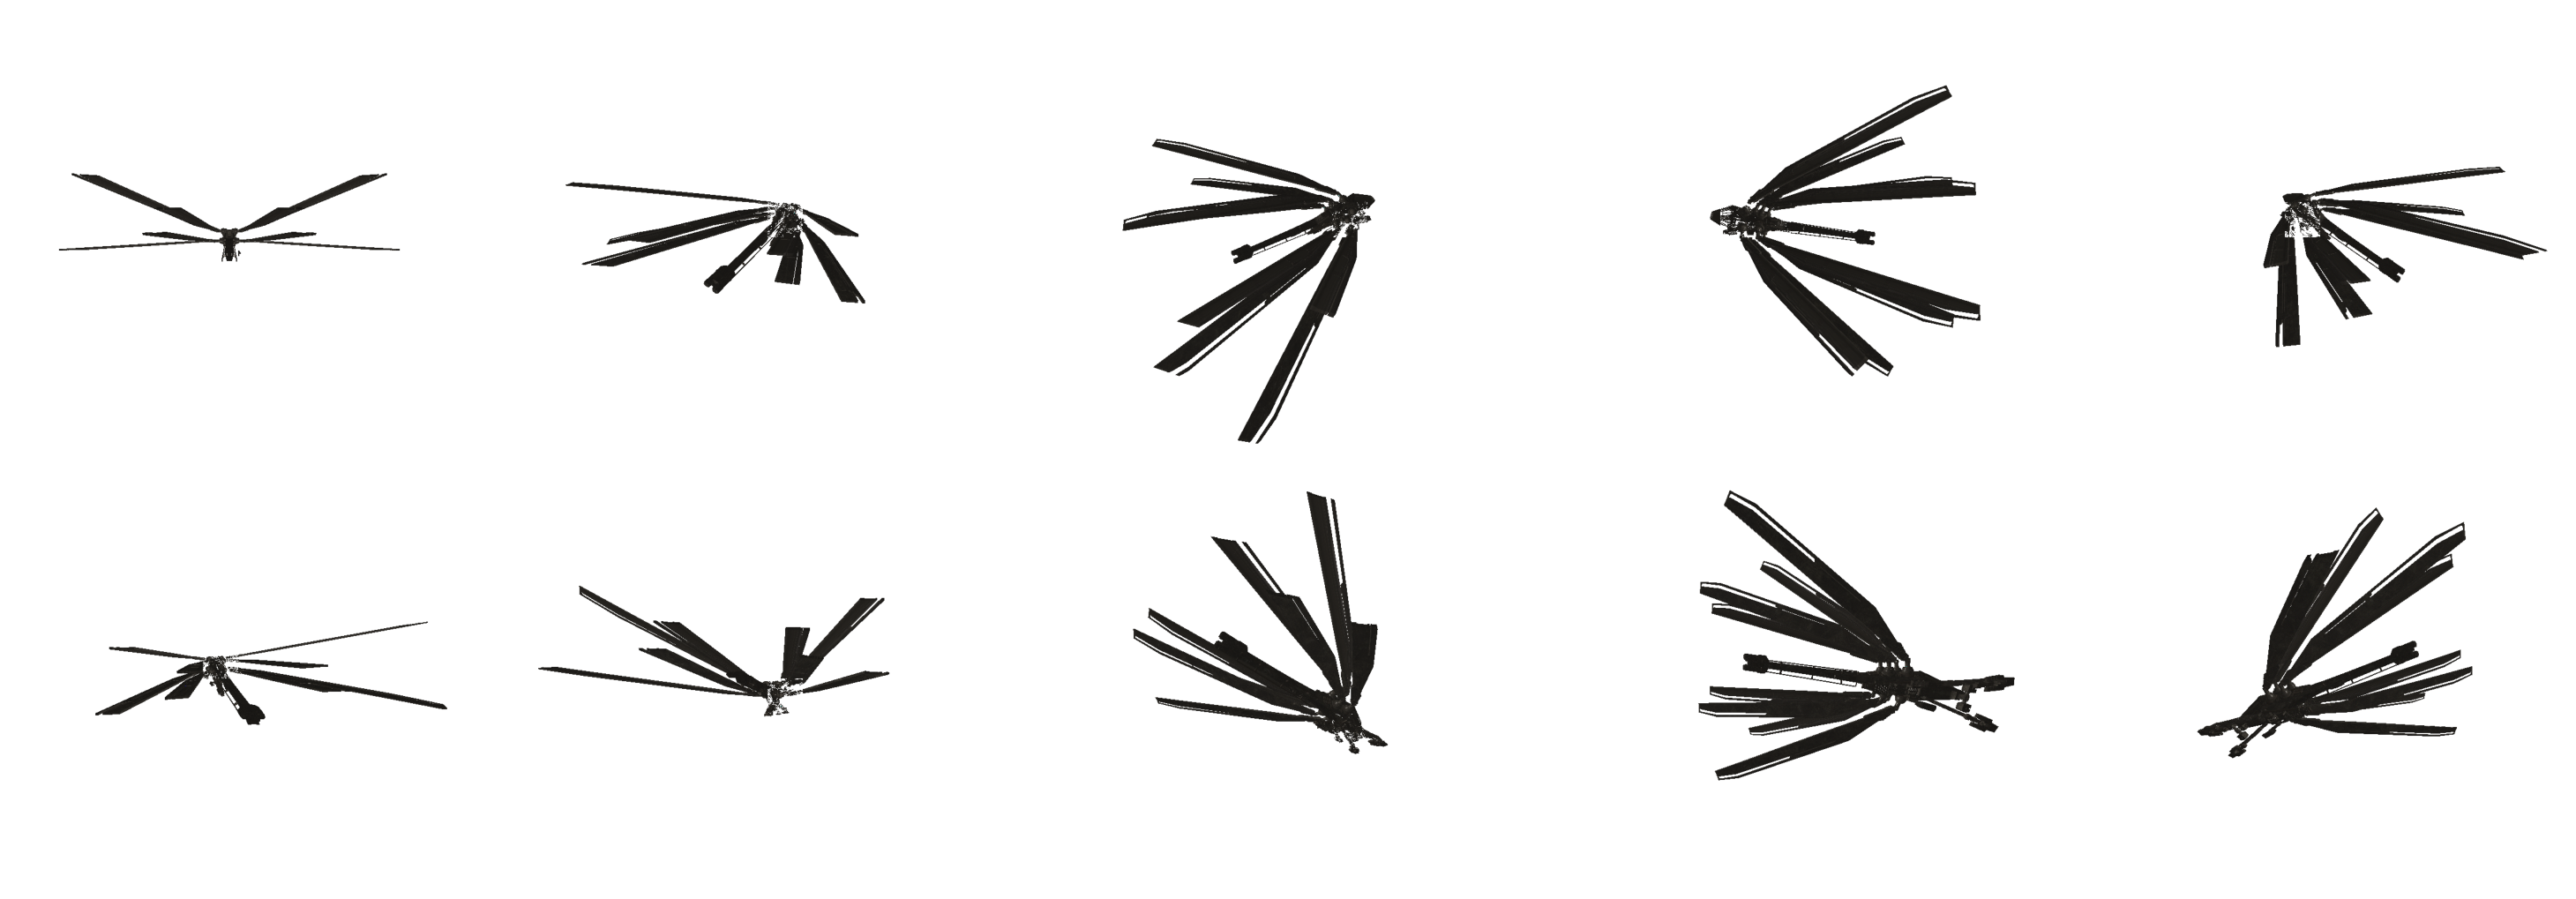

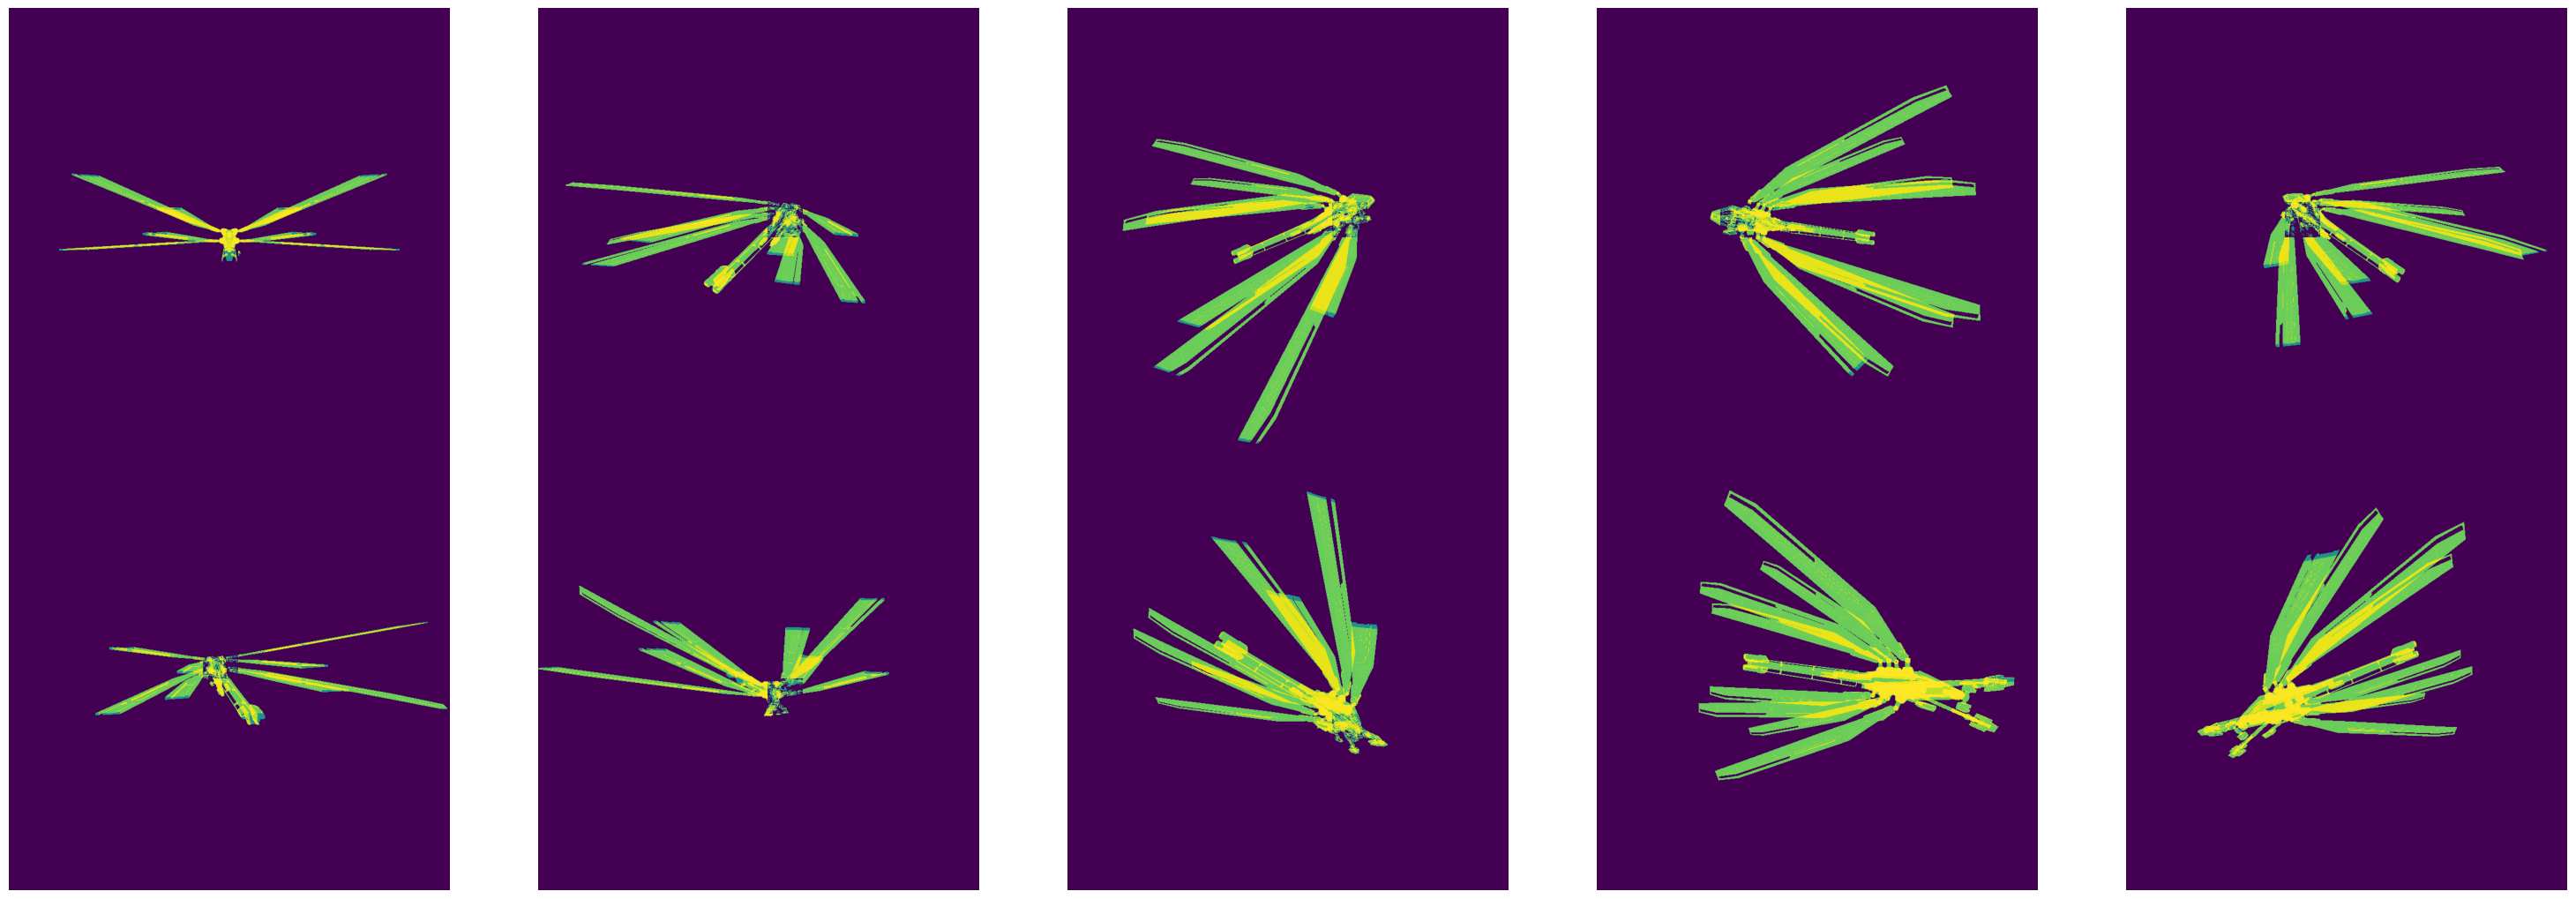

In [ ]:
target_rgb, target_sil = create_training_set(normalized_mesh=normalized_target_meshes,
                                              vis_renderer=vis_renderer,
                                              sil_renderer=sil_renderer,
                                             cameras=cameras)

#### Source Meshes

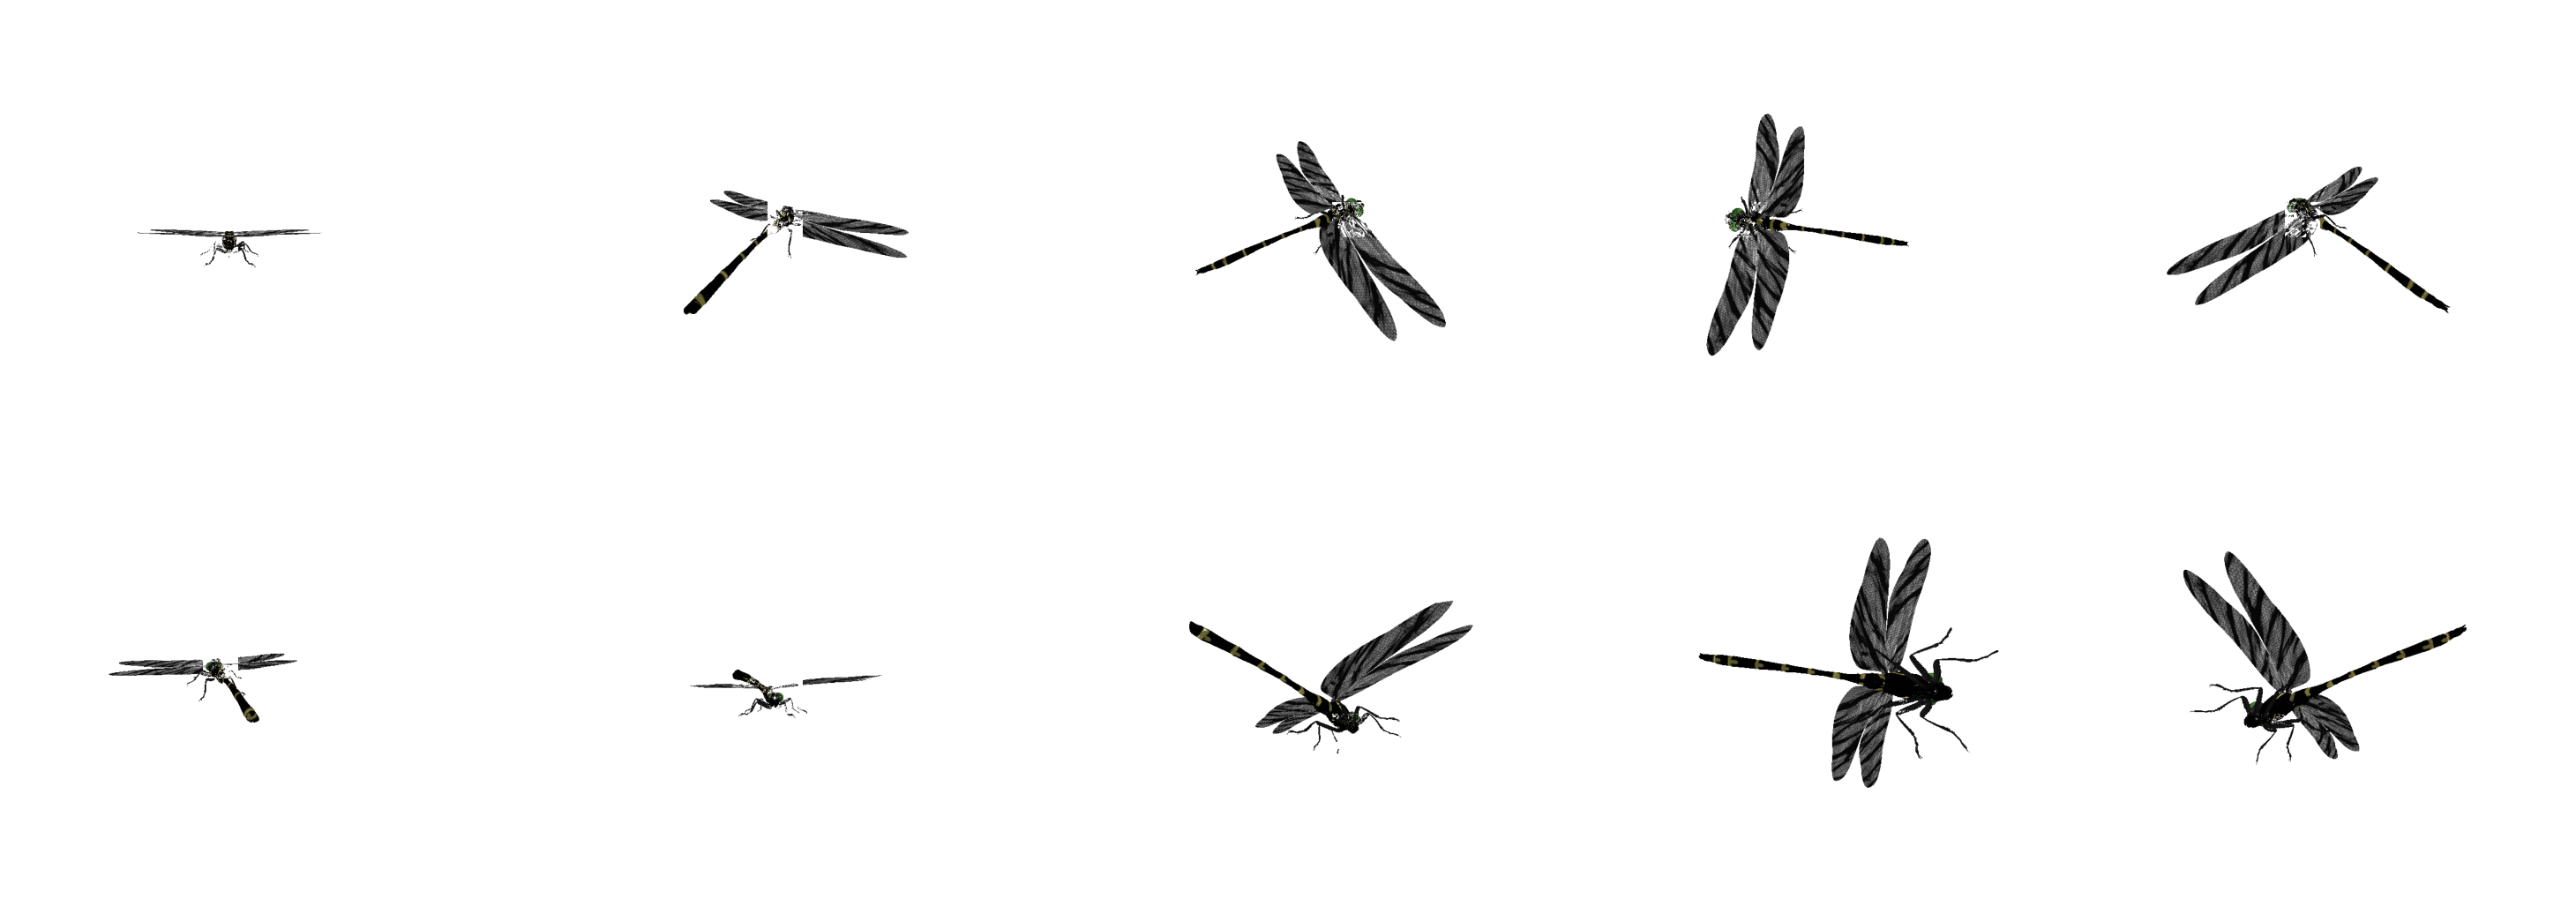

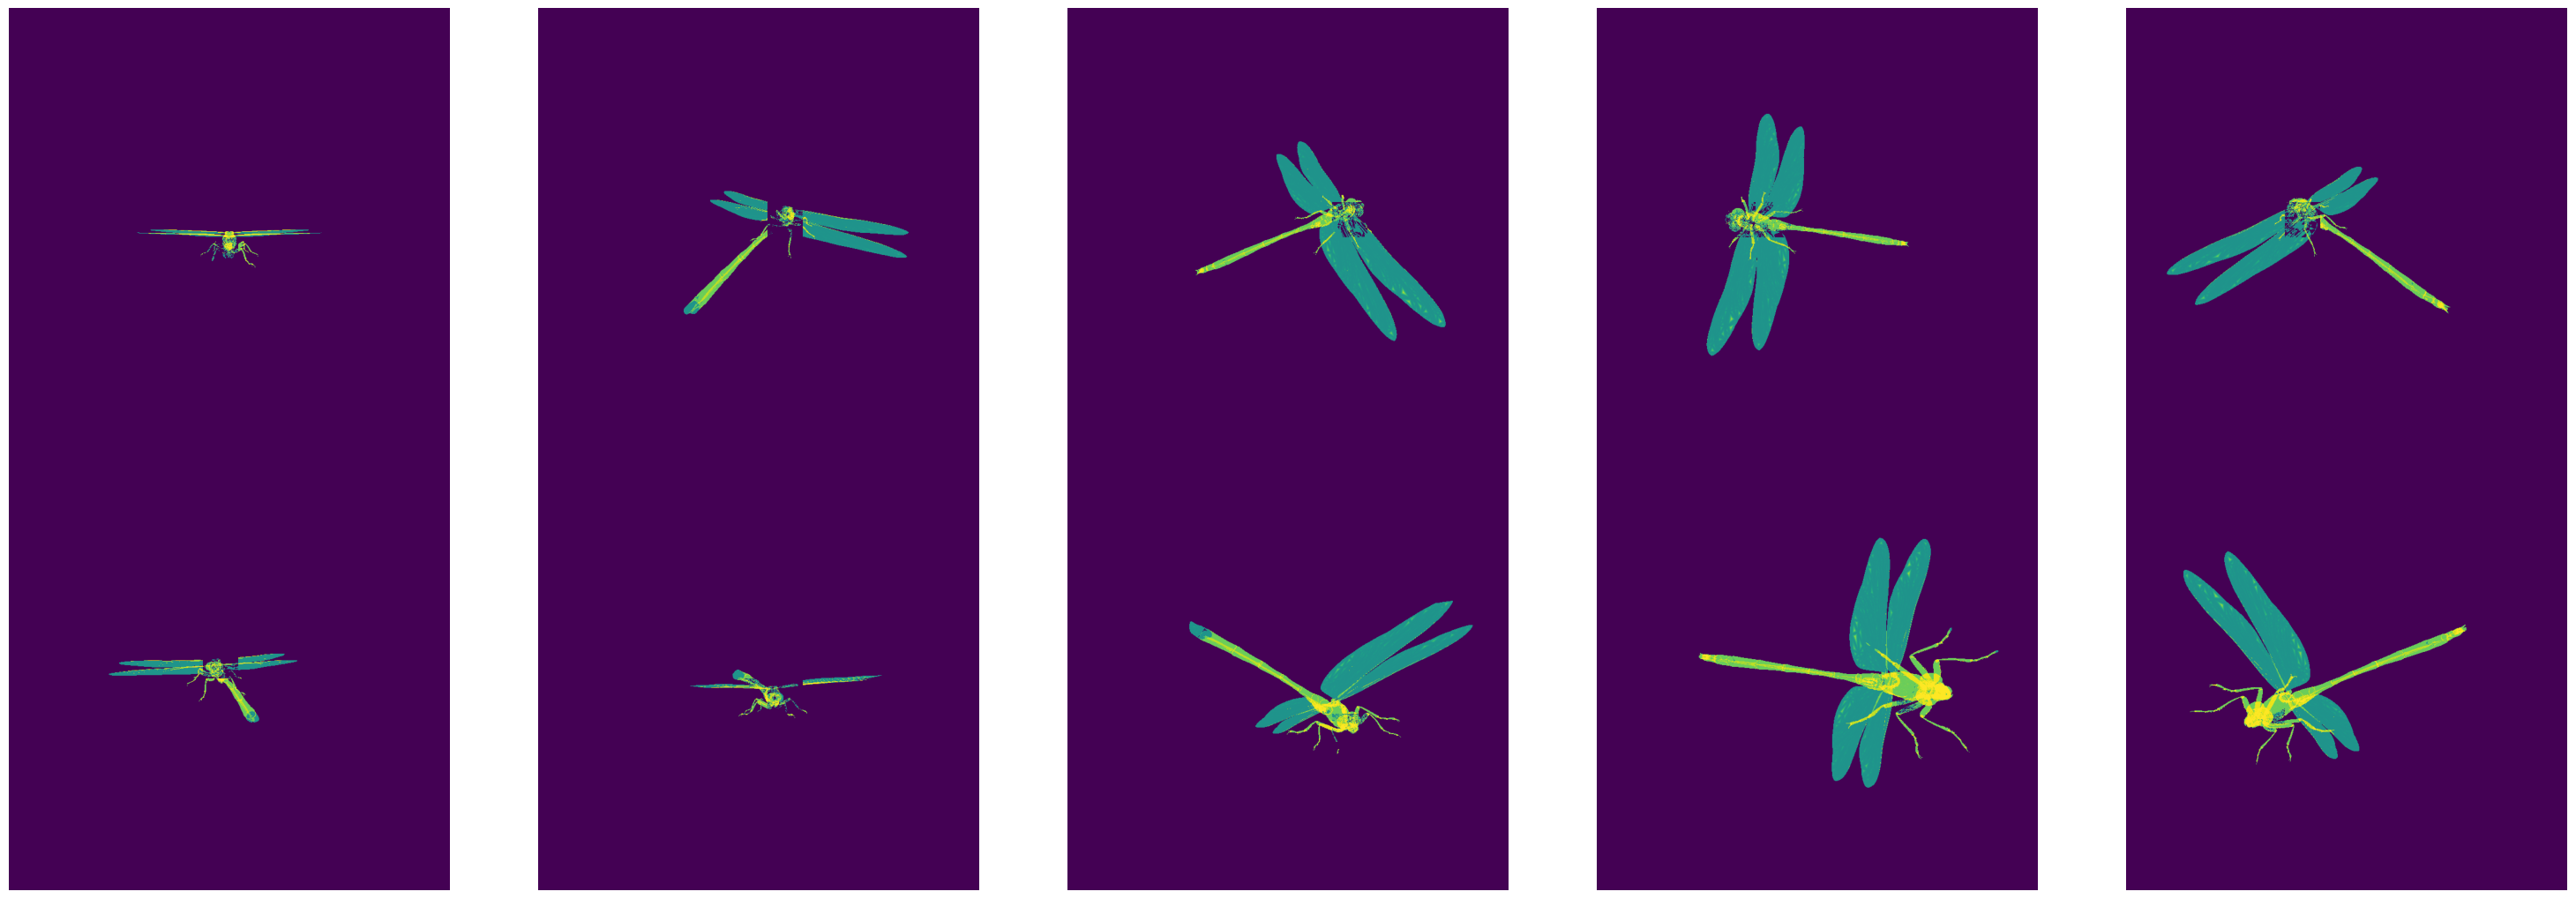

In [ ]:
src_rgb, src_sil = create_training_set(normalized_mesh=normalized_src_meshes,
                                              vis_renderer=vis_renderer,
                                              sil_renderer=sil_renderer,
                                             cameras=cameras)

In [ ]:
# rendered_src_imgs = vis_renderer(normalized_src_meshes, cameras=cameras)
# src_rgb = [img[..., :3] for img in rendered_src_imgs]

# display_single_render(rendered_src_imgs[1])

## Initialise the differentiable rasterizer:

In [ ]:
def create_differentiable_rasterizer(blur_radius: float,
                                     faces_per_pixel: int,
                                     image_size: int,
                                     device: torch.device,
                                     cameras: pytorch3d.renderer.FoVPerspectiveCameras,
                                     lights: pytorch3d.renderer.PointLights) -> pytorch3d.renderer.MeshRenderer:

  """
  """
  assert blur_radius != 0, "Blur Radius must be non-zero so that the rasterizer is differentiable"
  assert faces_per_pixel >1, "Number of faces per pixel must be greater than 1 so that smooth z-buffer is used"

  diff_raster_settings = RasterizationSettings(
      image_size=image_size,
      blur_radius=blur_radius,
      faces_per_pixel=faces_per_pixel,
      perspective_correct=False, #false does not apply perspective correction when computing barycentric coordinates for pixels
  )

  diff_renderer = MeshRenderer(
      rasterizer=MeshRasterizer(
          cameras=cameras,
          raster_settings=diff_raster_settings
      ),
      shader=SoftPhongShader(
          device=device,
          cameras=cameras,
          lights=lights
      )
  )

  return diff_renderer

In [ ]:
sigma = 1e-4
blur_radius = log(1. / 1e-4 - 1.) * sigma
faces_per_pixel = 10

diff_renderer = create_differentiable_rasterizer(blur_radius,
                                                  faces_per_pixel,
                                                  IMAGE_SIZE,
                                                  device,
                                                  cameras,
                                                  lights)

## Train the Differentiable rasterizer

In [ ]:
# I have refactored the code from the course: 3d Machine Learning with PyTorch3D
# https://www.educative.io/courses/3d-machine-learning-with-pytorch3d/texture-estimation
# into a function

def train(num_epochs: int,
          num_views: int,
          num_views_per_batch: int,
          mesh_loss_fn: torch.nn.modules.loss,
          optimizer: torch.optim,
          # src mesh arguments
          src_mesh: pytorch3d.structures.meshes.Meshes,
          src_verts_rgb: torch.tensor,
          deform_verts: torch.tensor,
          # targer mesh arguments
          target_silhouette: list[torch.tensor],
          target_verts_rgb: list[torch.tensor],
          # rendering arguments
          diff_renderer: pytorch3d.renderer.MeshRenderer,
          cameras: pytorch3d.renderer.FoVPerspectiveCameras,
          is_plotting_loss: bool = True,
          plot_interval: int = 100
          ) -> pytorch3d.structures.meshes.Meshes:

  """
  Trains the differentiable renderer to predict both shape and texture

  At the start of each epoch, a new instance of the mesh is created using the deformations from the previous epoch.
  Predicted meshses are compared to a rendering of the target mesh;
  Loss consists of a weighted combination of:
    * RGB loss (mean squared error): to optimise texture prediction
    * Silhouette loss (mean squared error): to optimise the shape of the mesh
    * Mesh edge loss ; regularizes the length of mesh edges so that they do not change too drastically
    * Mesh normal consistency loss ; penalizes differences in normal vectors between adjacent faces - resulting in smoother meshes
    * Mesh laplacian smoothing loss ; assesses mesh smoothness by applying a Laplacian operator to the vertices.

  Args:
    num_epochs: number of epochs to train the differentiable rasterizer
    num_views: number of views before applying gradients
    num_views_per_batch: plot intermediate mesh results (predictions) after this many iterations
    mesh_loss_fn: the PyTorch loss function that will be used to calculate between src and target meshses (both silhouette and rgb)
    optimizer: the optimizer to update mesh deformations (both shape and rgb)
    src_mesh: the normalized source mesh
    src_verts_rgb: the rgb values for every vertex in the source mesh
    deform_verts: the transformations to apply to the source mesh
    target_silhouette: a list of tensors representing the silhouette of the target meshes,
    target_verts_rgb: a list of tensors containing the rgb values for each vertex in the target mesh,
    diff_renderer: a mesh renderer with a differentiable rasterizer
    cameras: the camera used to set up the training data
    is_plotting_loss: boolean flag to stipulate whether a loss curve is shown at the end of training
    plot_interval: epoch interval for which intermediate results are shown

  Returns:
    The predicted target mesh

  Raises:
    AssertionError if the number of views per epoch is greater than the size of the training set
  """
  assert num_views_per_batch <= num_views, "Number of views per batch is expected to be smaller than training set"

  losses = {
    'rgb': {'weight': 1.0, 'values': []},
    'silhouette': {'weight': 1.0, 'values': []},
    'edge': {'weight': 1.0, 'values': []},
    'normal': {'weight': 0.1, 'values': []},
    'laplacian': {'weight': 1.0, 'values': []}
 }

  for i in range(num_epochs):
      optimizer.zero_grad()
      # re-initialise loss to calculate loss per-epoch
      loss = {key: torch.tensor(0.0, device=device) for key in losses}
      # setup temporary copy of mesh
      new_src_mesh = src_mesh.offset_verts(deform_verts)
      new_src_mesh.textures = TexturesVertex(verts_features=src_verts_rgb)

      # compute shape prior losses
      update_mesh_shape_prior_losses(new_src_mesh, loss)

      # render images to calculate loss
      # provide option to train with mini-batch for regularization effect (using num_views_per_batch)
      # mini-batch training can have a regularizing effect
      for j in np.random.permutation(num_views).tolist()[:num_views_per_batch]:
          pred_imgs = diff_renderer(new_src_mesh, cameras=cameras[j])

          # calculate loss for silhouette to evaluate shape of mesh
          pred_sil = pred_imgs[..., 3]
          loss_sil = mesh_loss_fn(pred_sil, target_silhouette[j].unsqueeze(0))
          loss['silhouette'] += loss_sil / num_views_per_batch

          # calculate loss for rgb texture values to evaluate texture of mesh
          pred_rgb = pred_imgs[..., :3]
          loss_rgb = mesh_loss_fn(pred_rgb, target_verts_rgb[j].unsqueeze(0))
          loss['rgb'] += loss_rgb / num_views_per_batch

          # memory management
          del pred_imgs, pred_sil, pred_rgb, loss_sil, loss_rgb
          torch.cuda.empty_cache()


      # compute weighted sum of losses
      sum_loss = torch.tensor(0.0, device=device)
      for key, val in loss.items():
          sum_loss += val * losses[key]['weight']
          losses[key]['values'].append(val.detach().cpu().item())

      # display latest mesh
      if i % plot_interval == 0:
          # make this plotting happen on cpu
          display_prediction(new_src_mesh,
                            vis_renderer,
                            cameras,
                            j,
                            target_image=target_rgb[j],
                            title=f'iter: {i:d}', silhouette=False)

      sum_loss.backward()
      optimizer.step()

  if is_plotting_loss:
    plot_losses(losses)
  return new_src_mesh

In [ ]:
stop

NameError: name 'stop' is not defined

### Iteration 1:

In [ ]:
src_deform_verts = torch.full(normalized_src_mesh.verts_packed().shape, 0.0, device=device,
                            requires_grad=True)

src_verts_rgb = torch.full([1, src_deform_verts.shape[0], 3], 0.5,
                              device=device, requires_grad=True)

In [ ]:
# initialise hyperparameters
num_epochs = 300
num_views_per_batch = 12
TEST_IDX = 4
lr = 1.0
lr_momentum = 0.9
# the vertices of the mesh and the rgb values for each vertex are treated as learnable parameters
optimizer = torch.optim.SGD([src_deform_verts, src_verts_rgb], lr=lr,
                            momentum=lr_momentum)

In [ ]:
pred_mesh = train(
                  num_epochs = num_epochs,
                  num_views = NUM_VIEWS,
                  num_views_per_batch = num_views_per_batch,
                  mesh_loss_fn= torch.nn.MSELoss(),
                  optimizer = optimizer,
                  # src mesh data
                  src_mesh = normalized_src_mesh,
                  src_verts_rgb = src_verts_rgb,
                  deform_verts = src_deform_verts,
                  # target mesh data
                  target_silhouette = target_sil,
                  target_verts_rgb = target_rgb,
                  # rendering variables
                  diff_renderer = diff_renderer,
                  cameras = cameras,
                  plot_interval=25,
              )

### Iteration 1 Results

In [ ]:
display_prediction(pred_mesh,
                   vis_renderer,
                   cameras = cameras,
                   test_idx=TEST_IDX,
                   target_image=target_rgb[TEST_IDX], silhouette=False)

In [ ]:
# download .obj file to import into blender
# save_mesh_as_obj(pred_mesh, 'pred_orthinothopter.obj', is_downloading=True)

## Iteration 2:

### Source Vertex upsampling

In [ ]:
n_src_verts = src_mesh.verts_list()[0].shape[0]
n_src_faces = src_mesh.faces_list()[0].shape[0]
print(n_src_verts)
print(n_src_faces)

26809
48730


In [ ]:
n_target_verts = target_mesh.verts_list()[0].shape[0]
n_target_faces = target_mesh.faces_list()[0].shape[0]
print(n_target_verts)
print(n_target_faces)

1206181
2407402


In [ ]:
subdivided_src_mesh = upsample_mesh(src_mesh=src_mesh,
                                    texture_colour=[0.6, 0.3, 0.8])

Subdivided number of vertices: 101444


In [ ]:
subdivided_src_mesh = normalize_mesh(subdivided_src_mesh, device='cpu')
subdivided_src_meshes = subdivided_src_mesh.extend(NUM_VIEWS)
subdivided_src_meshes = subdivided_src_meshes.to(device)

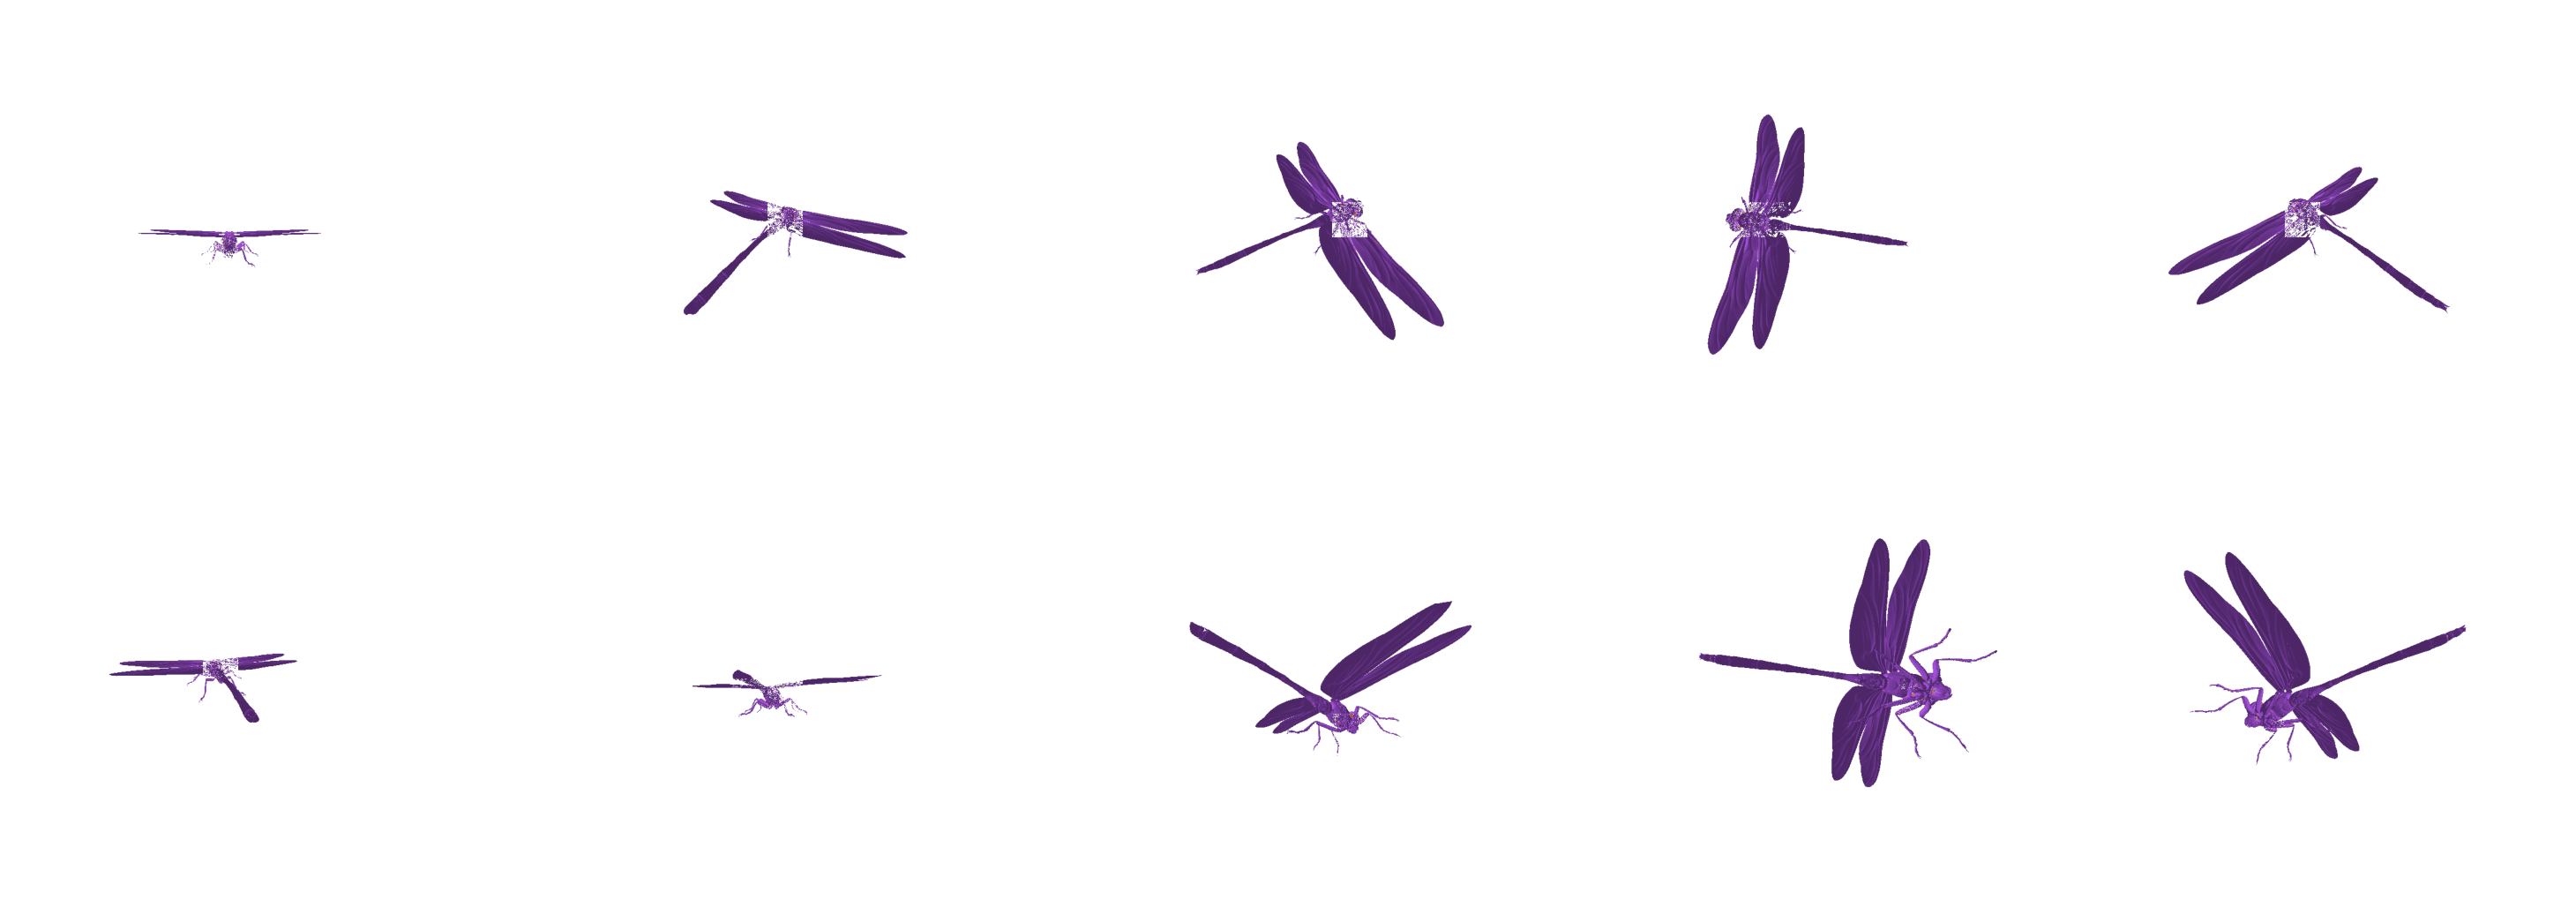

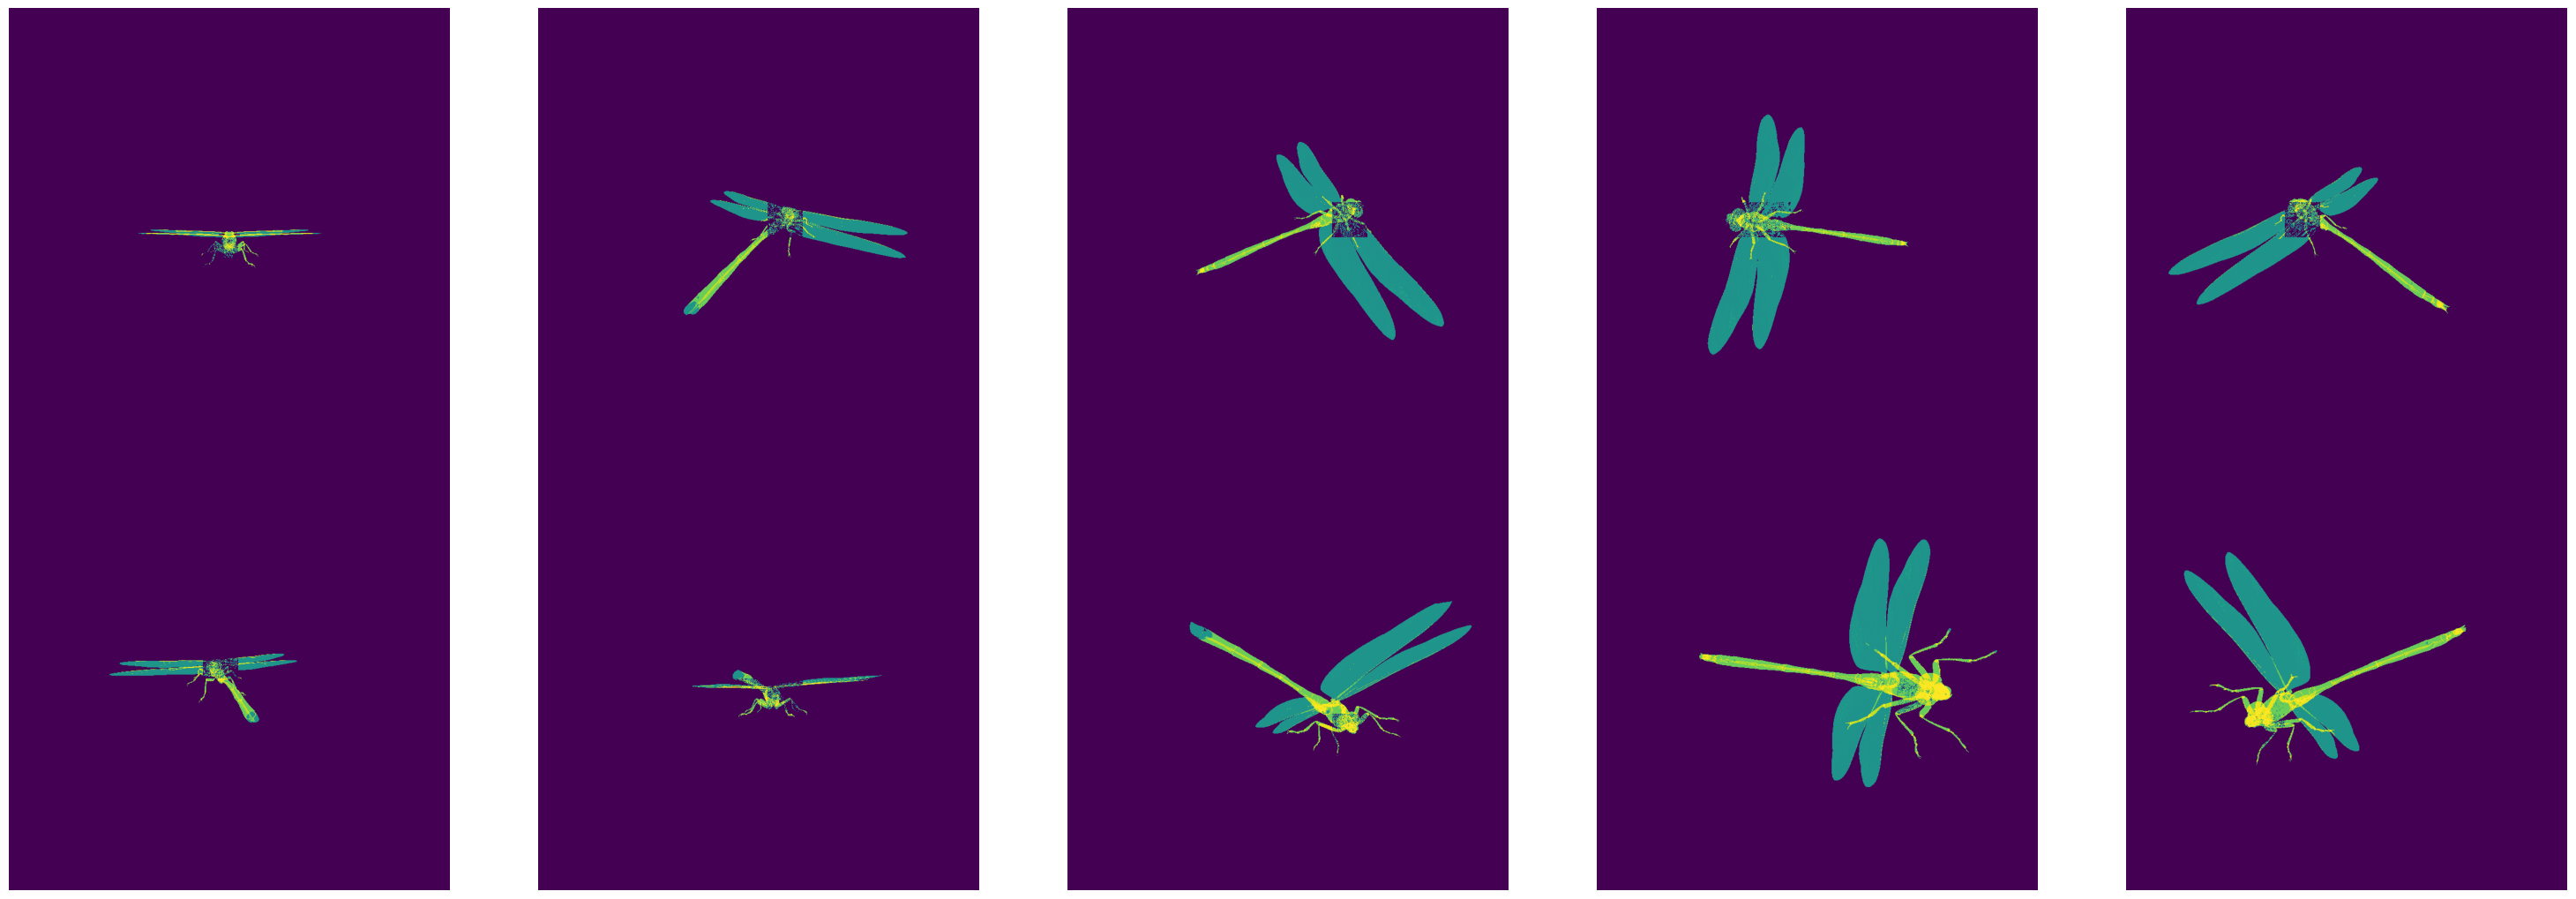

In [ ]:
sub_src_rgb, sub_src_sil = create_training_set(normalized_mesh=subdivided_src_meshes,
                                              vis_renderer=vis_renderer,
                                              sil_renderer=sil_renderer,
                                             cameras=cameras)

### Target vertex downsampling

In [ ]:
downsampled_mesh = downsample_mesh(file_path= target_mesh_path,
                                   n_target_faces = 300000,
                                   colour = [0, 0, 0])

Original mesh: 1212208 vertices, 2407402 faces
Downsampled mesh: 217794 vertices, 431050 faces


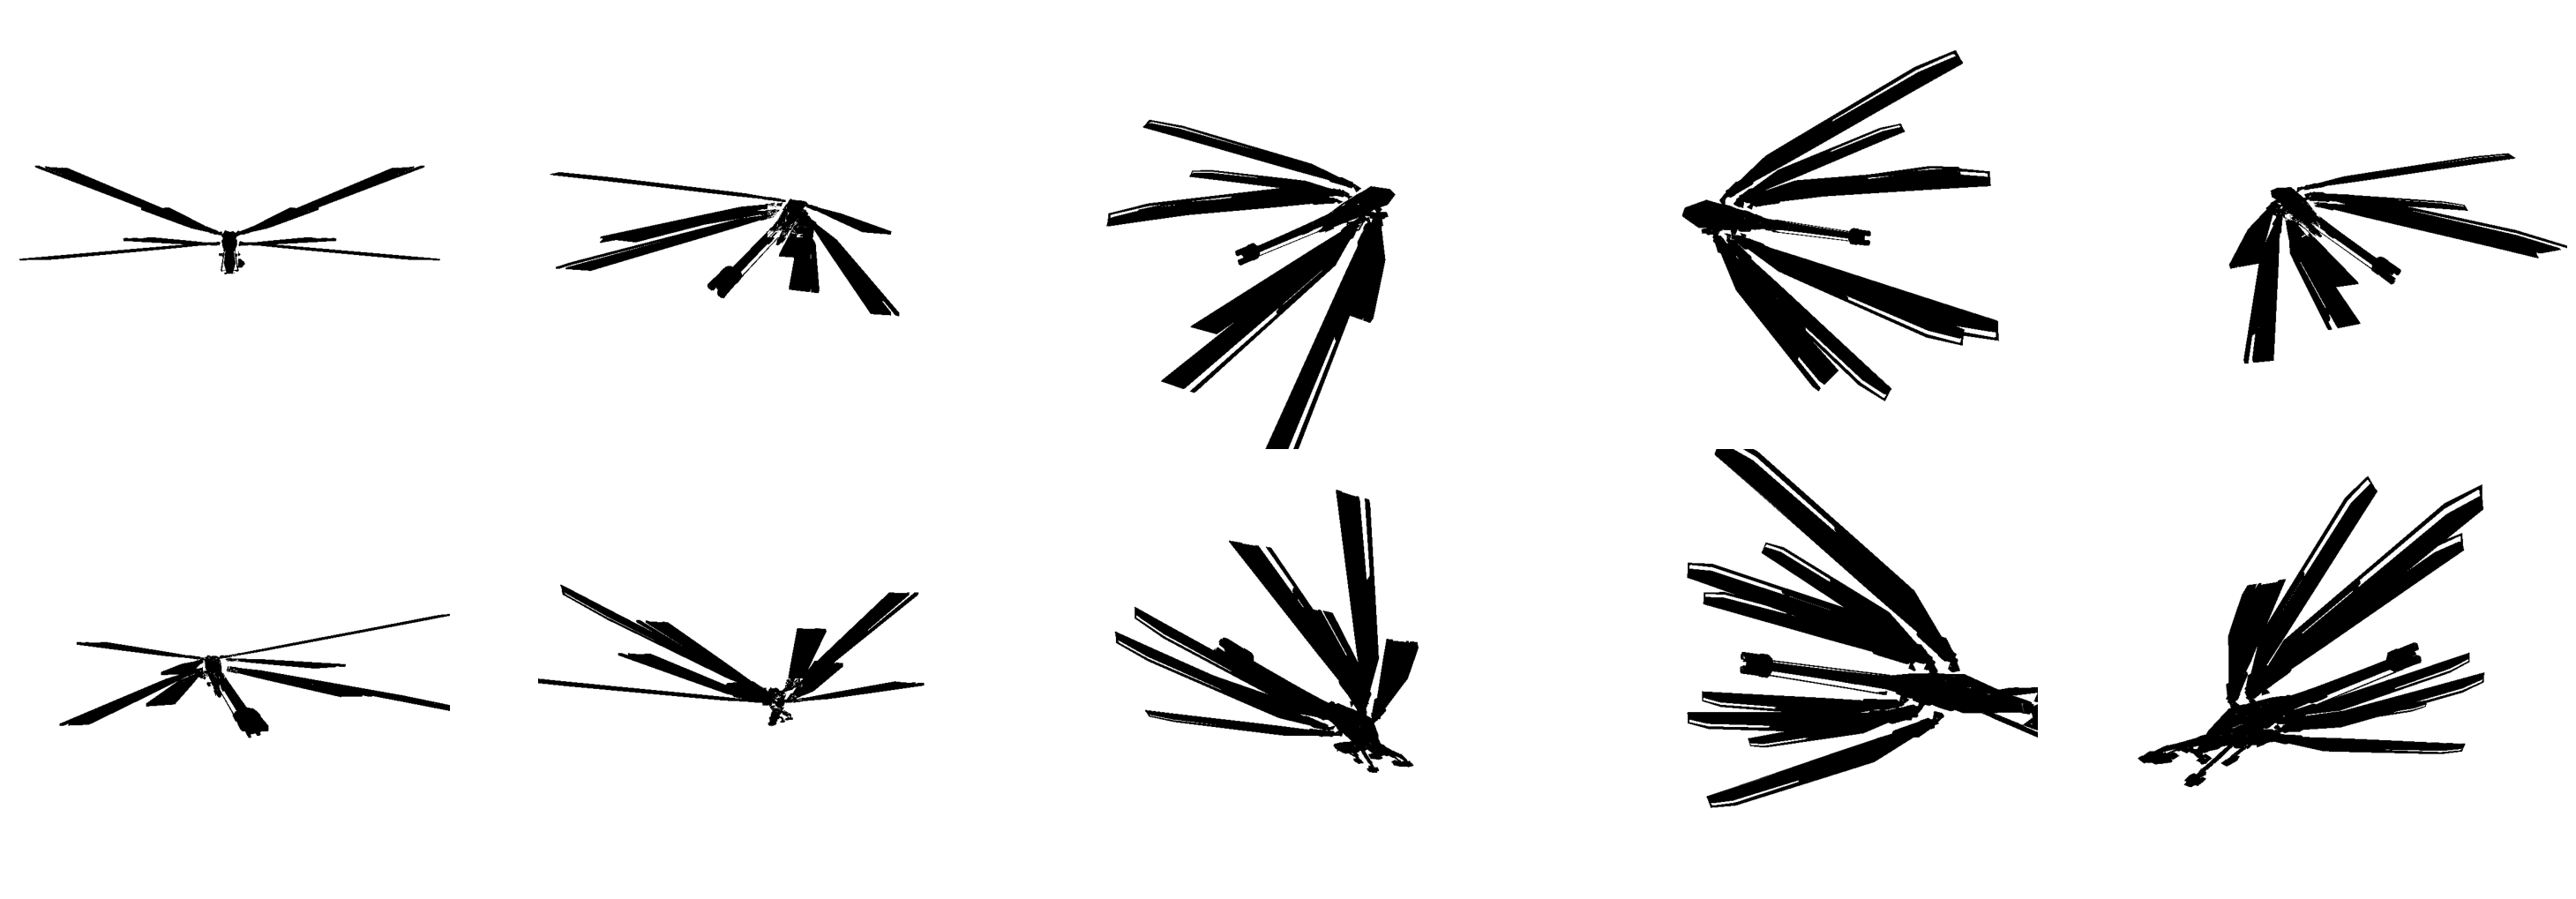

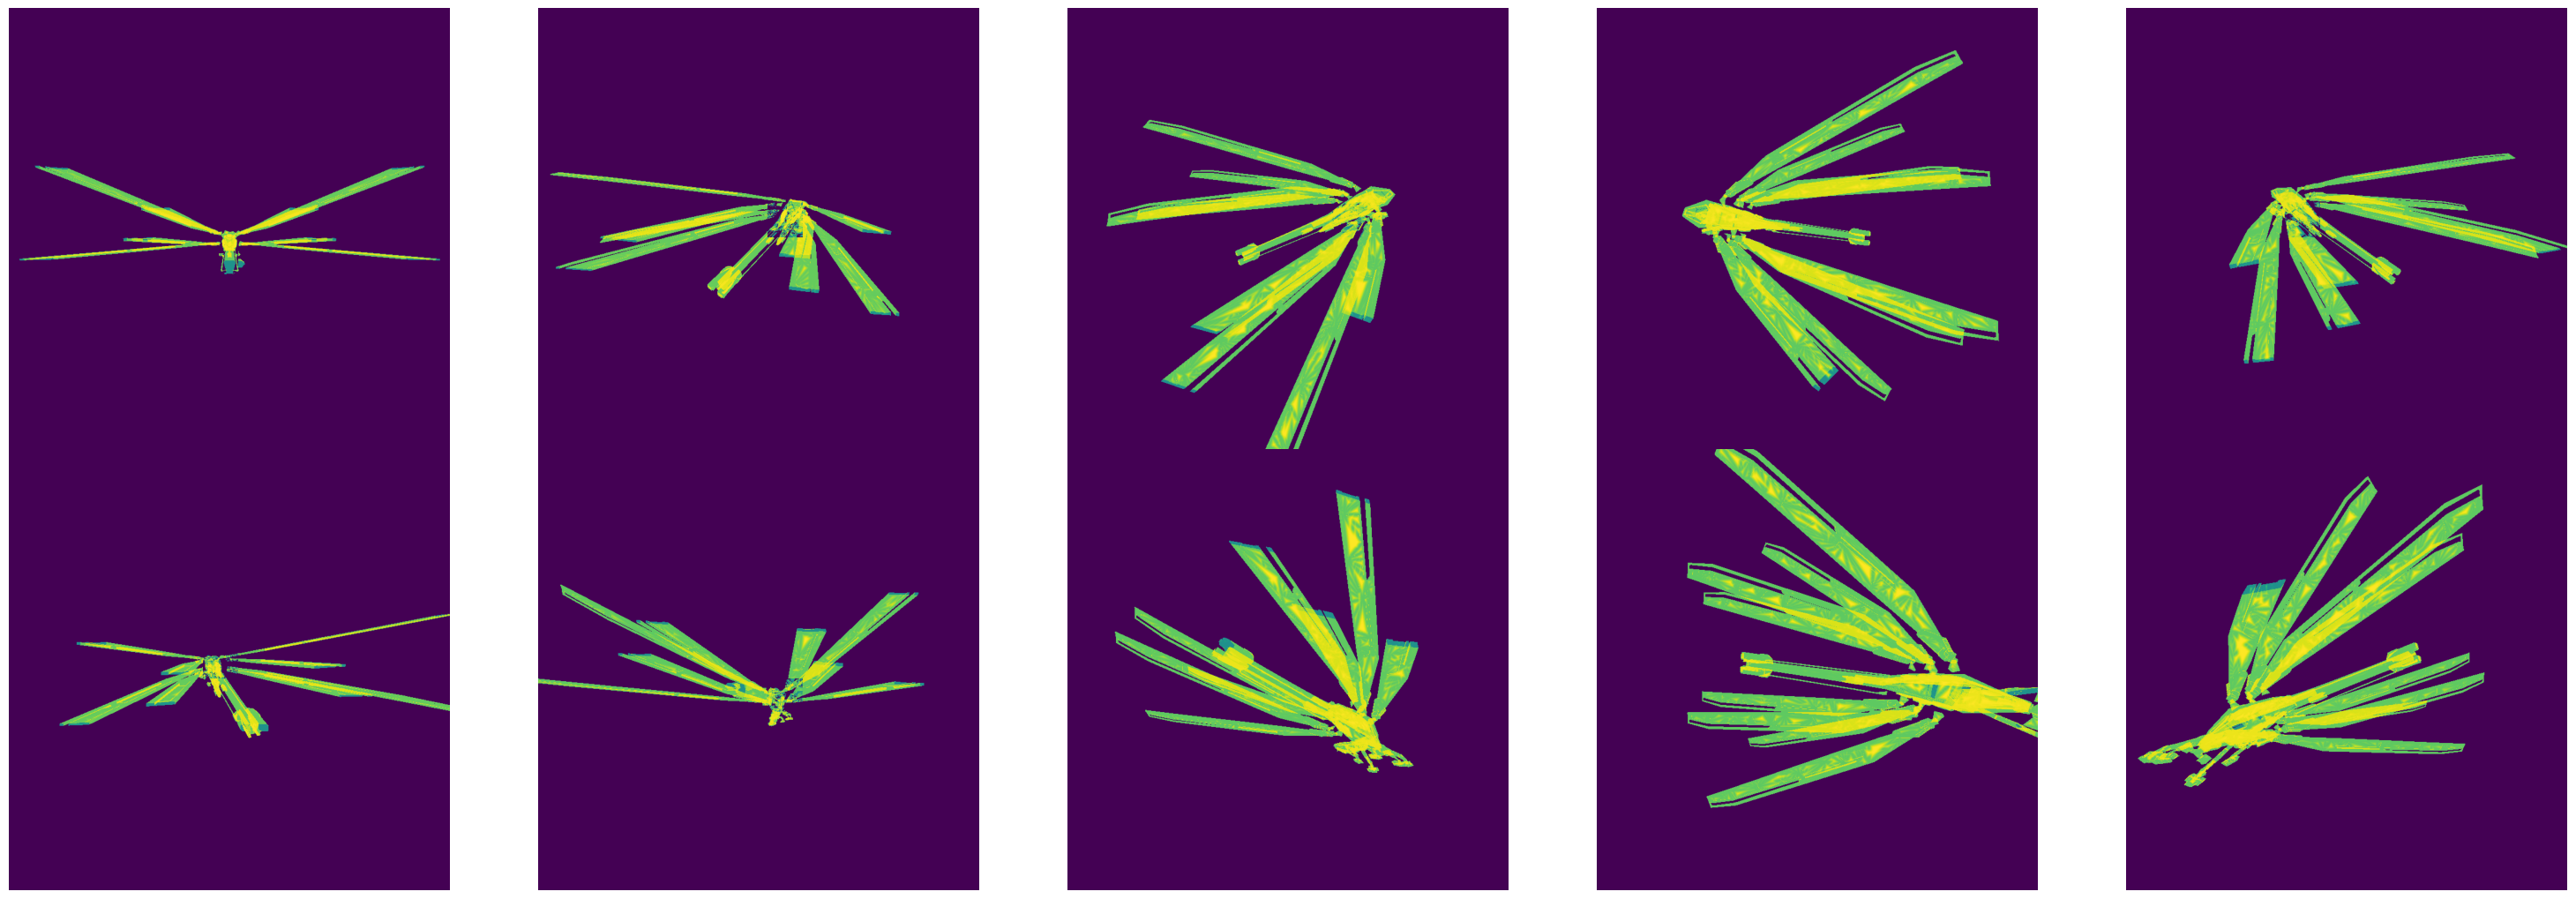

In [ ]:
# NORMALIZE TARGET MESH AND EXTEND
downsampled_target_mesh = normalize_mesh(downsampled_mesh, device='cpu') #this is not the final training data so keep on cpu to keep GPU RAM usage low
downsampled_target_meshes = downsampled_target_mesh.extend(NUM_VIEWS)
downsampled_target_meshes = downsampled_target_meshes.to(device)

target_rgb, target_sil = create_training_set(normalized_mesh=downsampled_target_meshes,
                                              vis_renderer=vis_renderer,
                                              sil_renderer=sil_renderer,
                                             cameras=cameras)

### Training

In [ ]:
src_deform_verts = torch.full(subdivided_src_mesh.verts_packed().shape, 0.0, device=device,
                            requires_grad=True)

src_verts_rgb = torch.full([1, src_deform_verts.shape[0], 3], 0.5,
                              device=device, requires_grad=True)

In [ ]:
# initialise hyperparameters
num_epochs = 600
num_views_per_batch = 12
TEST_IDX = 4
lr = 1.0
lr_momentum = 0.9
# the vertices of the mesh and the rgb values for each vertex are treated as learnable parameters
optimizer = torch.optim.SGD([src_deform_verts, src_verts_rgb], lr=lr,
                            momentum=lr_momentum)

/usr/local/lib/python3.11/dist-packages/pytorch3d/ops/laplacian_matrices.py:51: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:644.)
  A = torch.sparse.FloatTensor(idx, ones, (V, V))
<ipython-input-11-70ccb9376fc9>:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(20, 10))


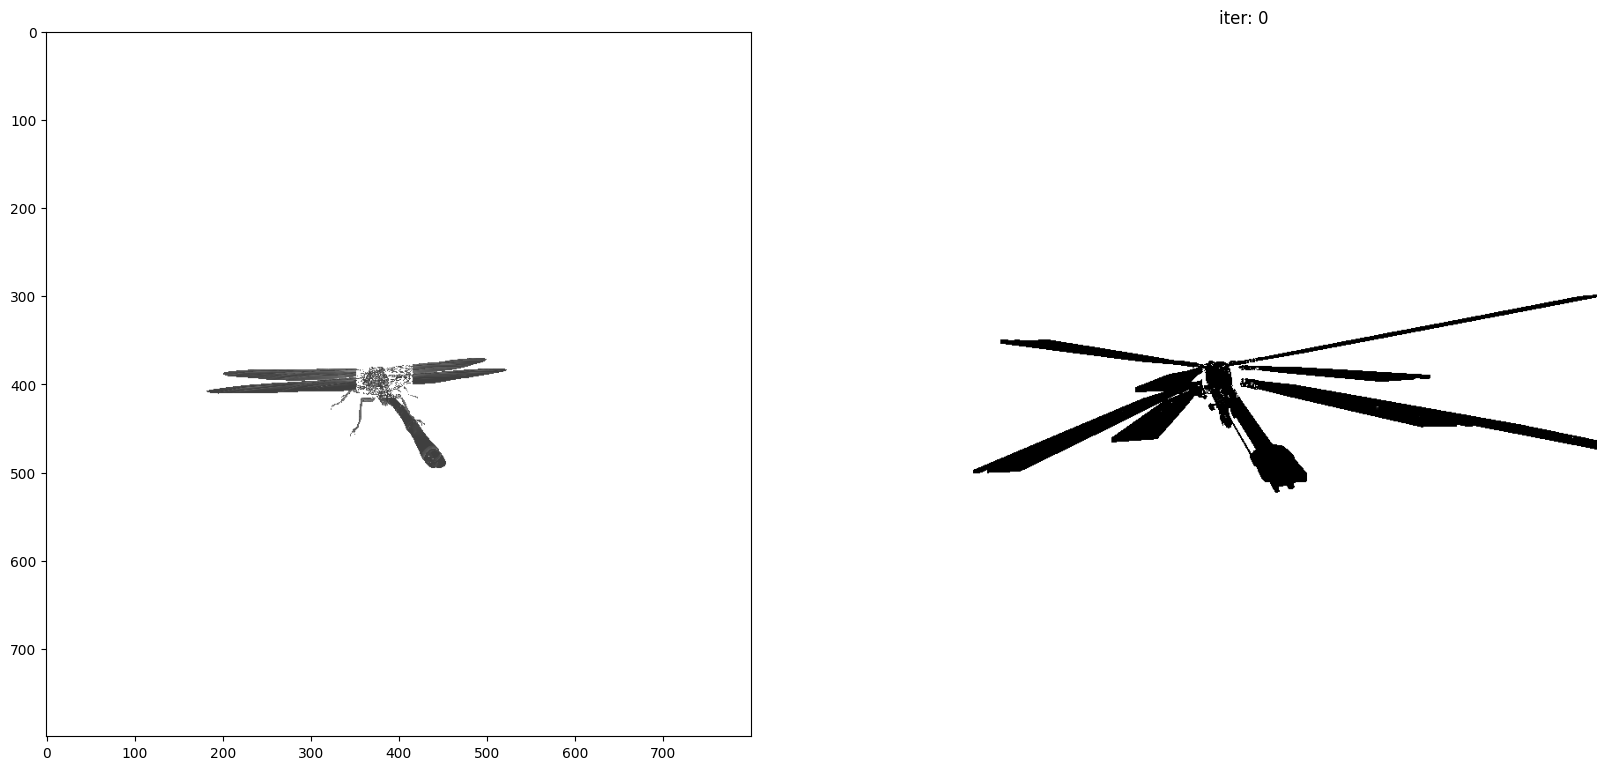

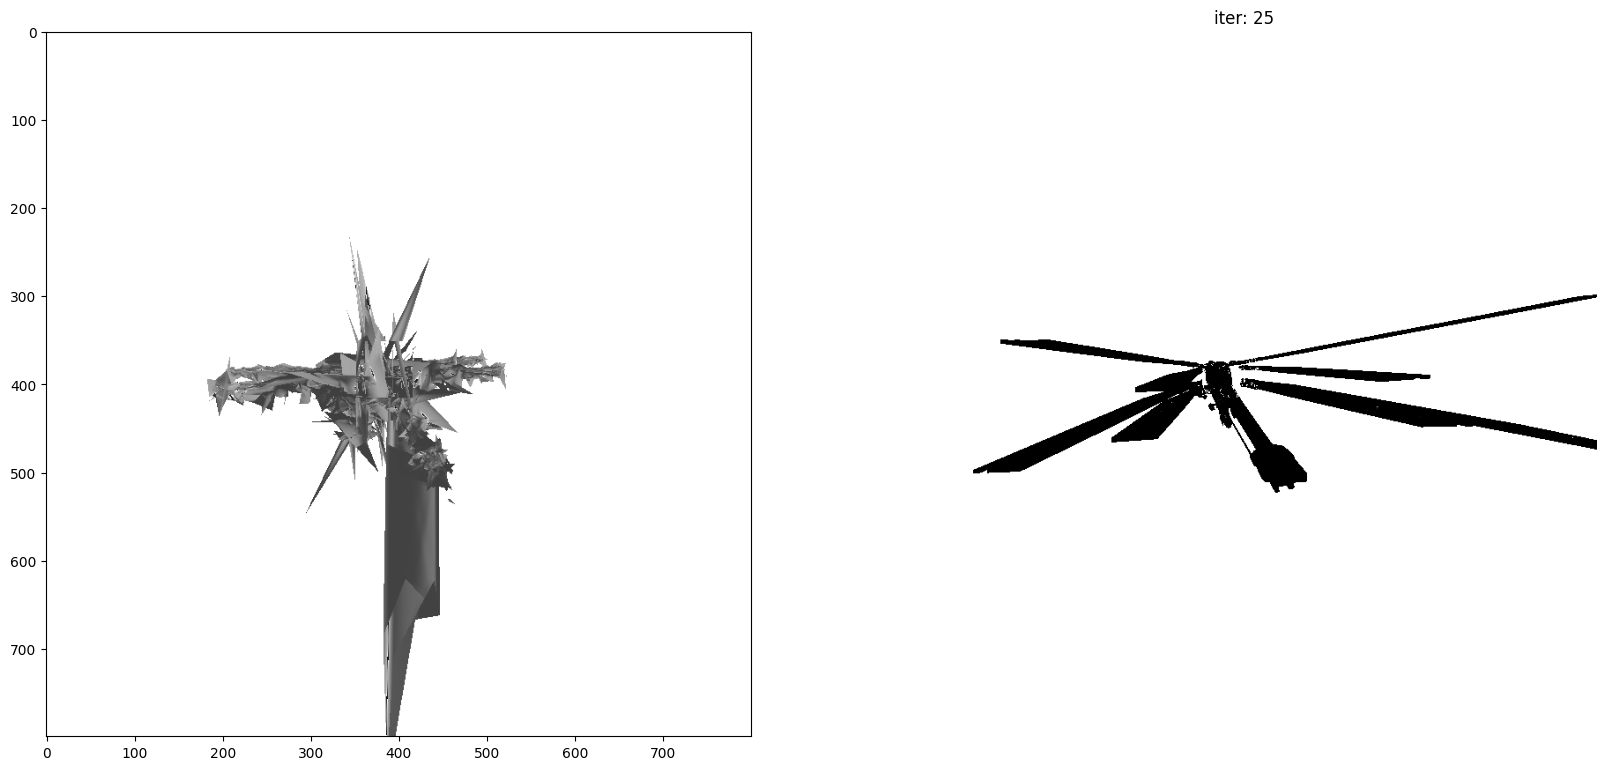

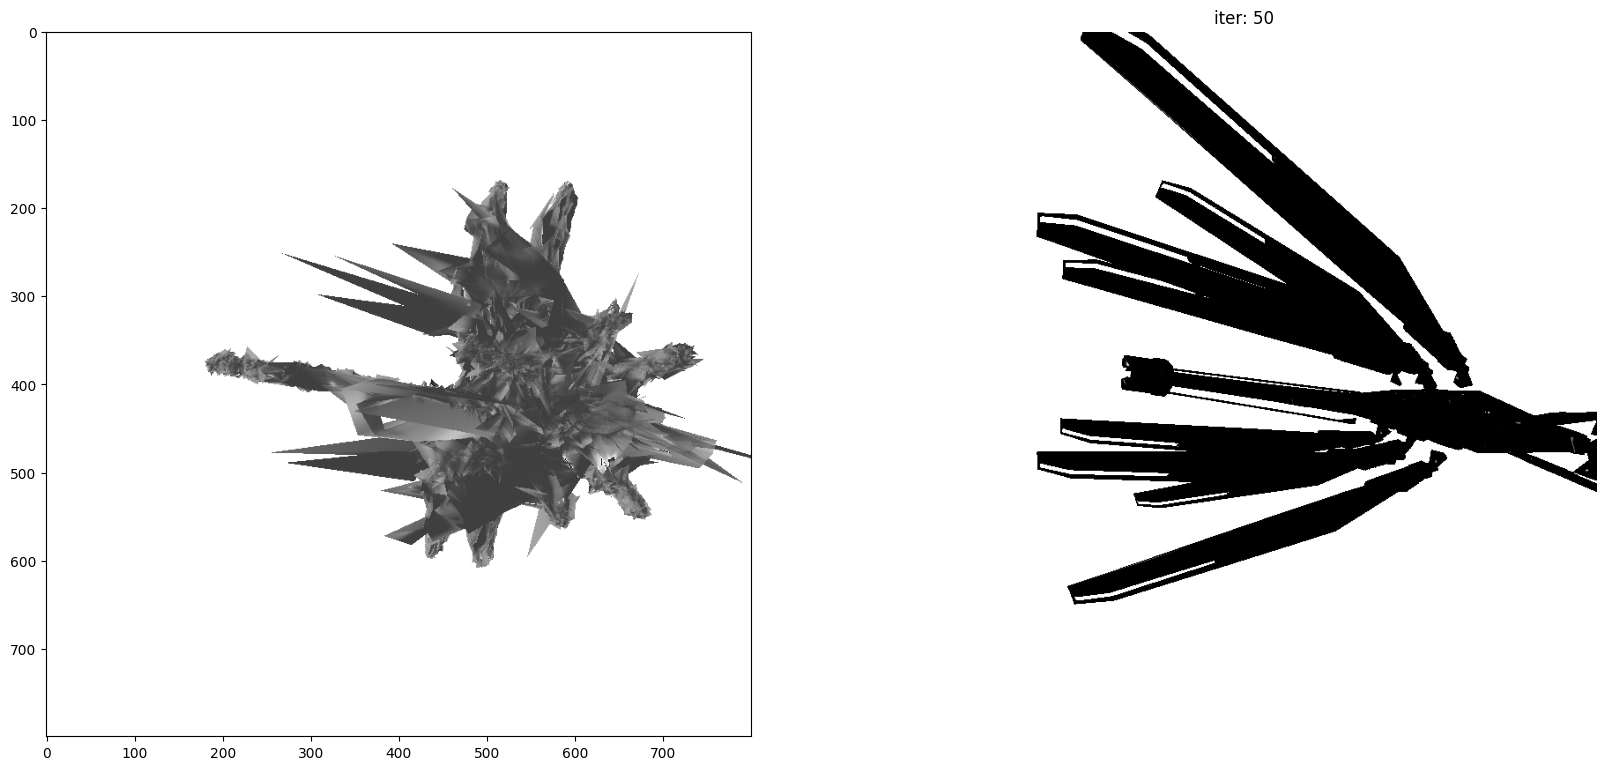

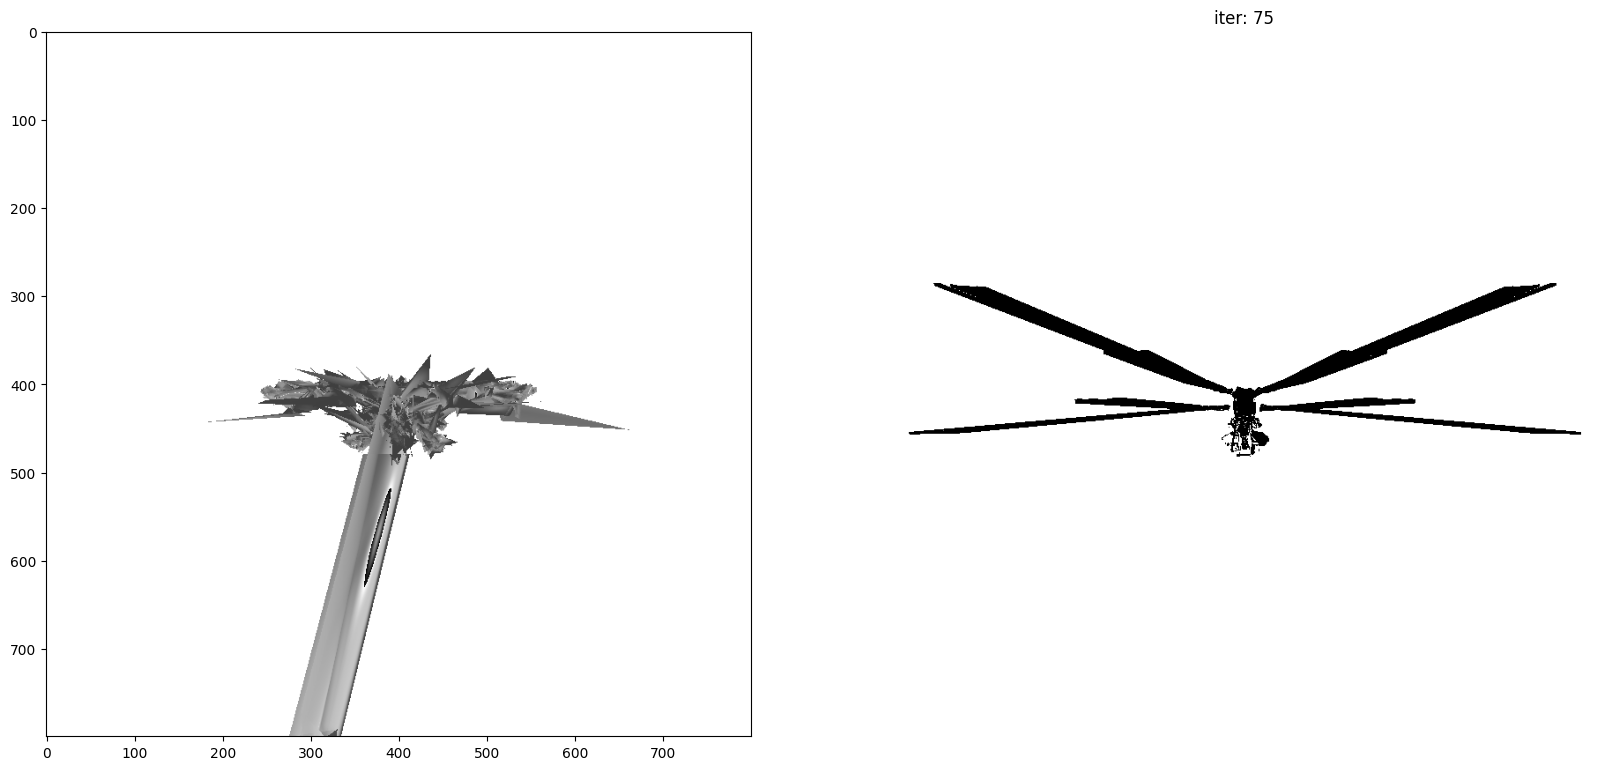

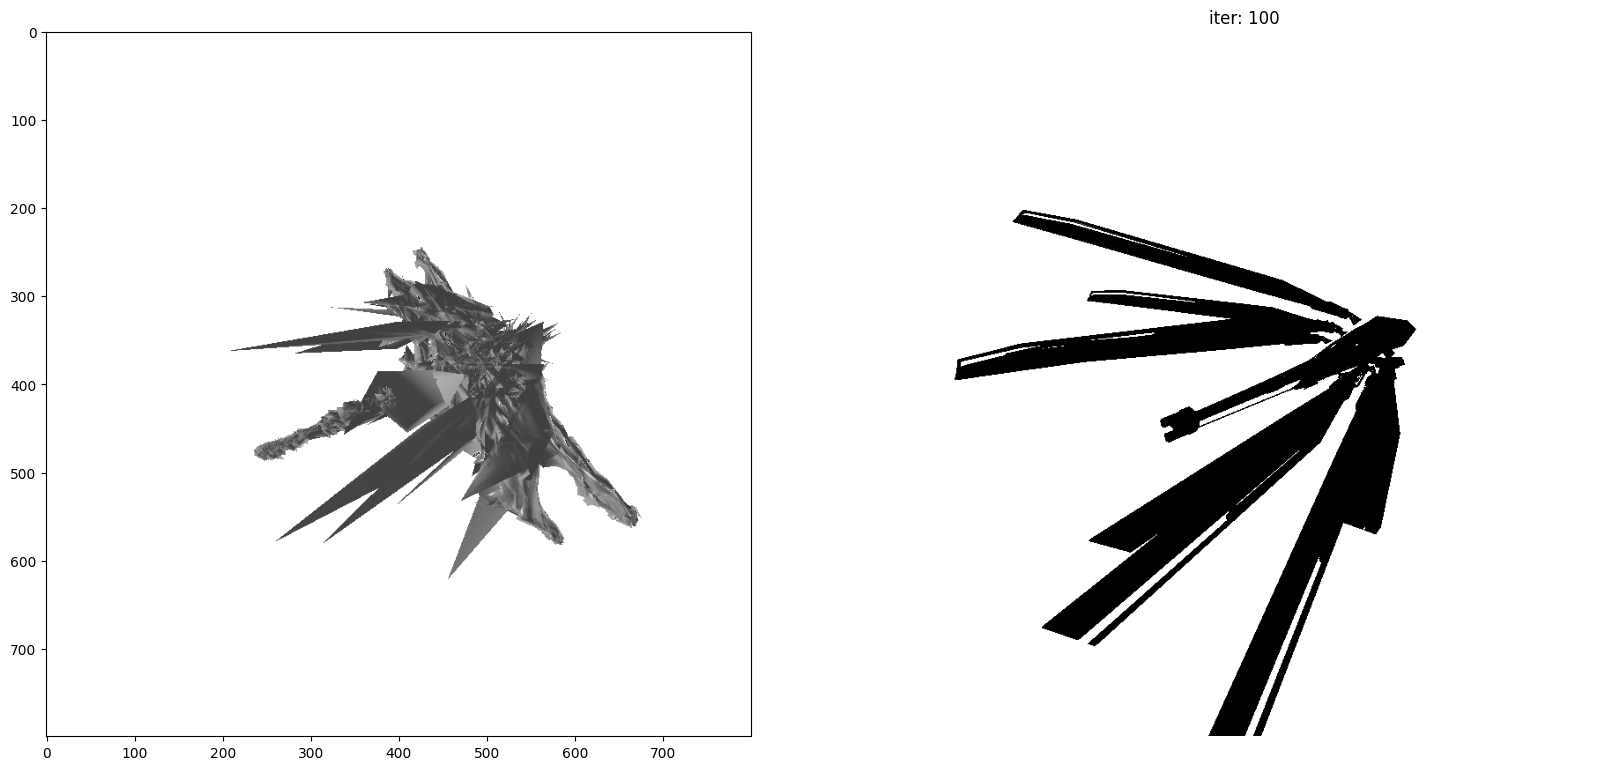

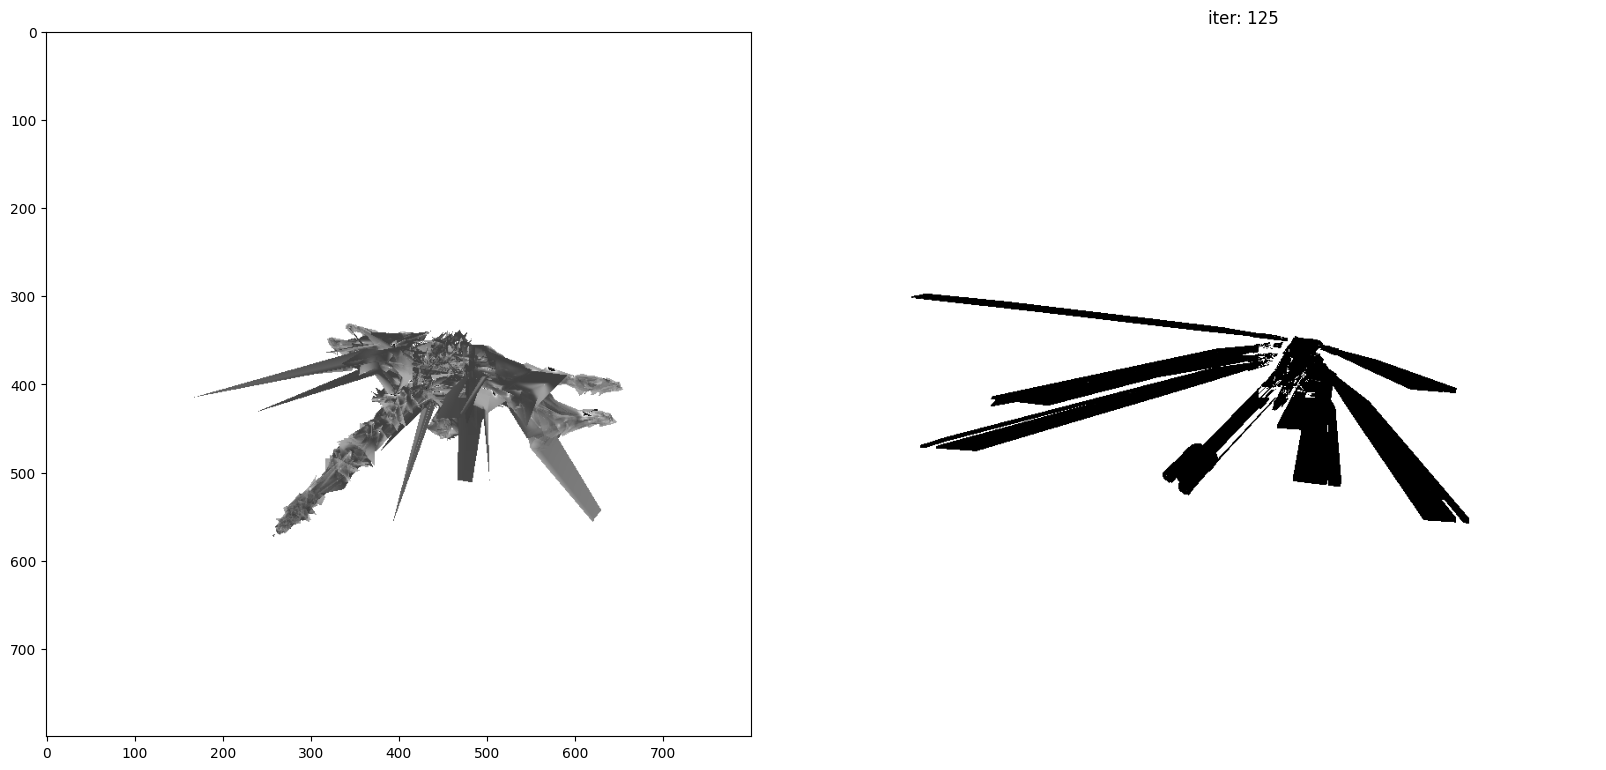

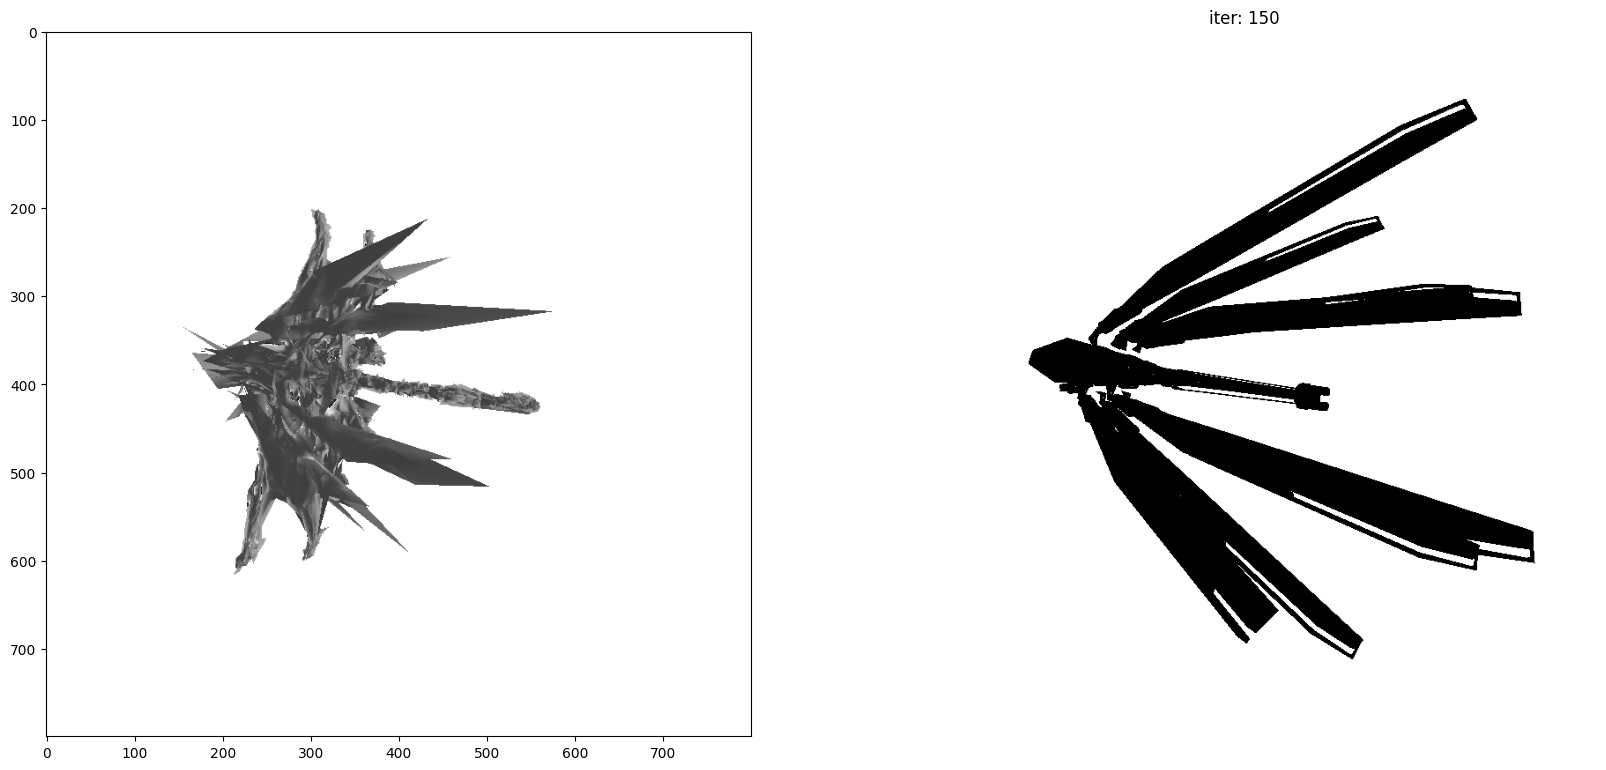

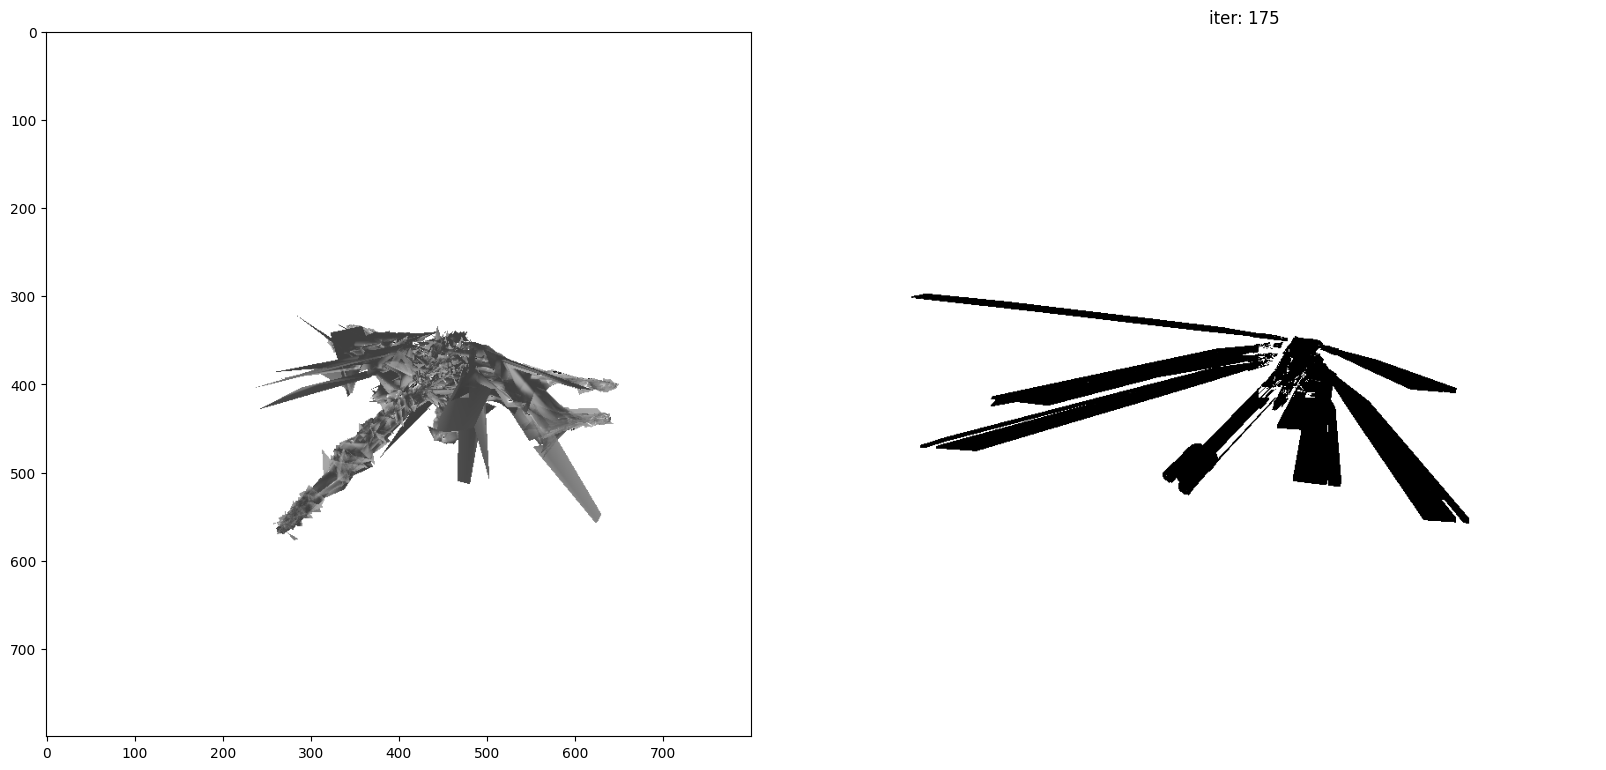

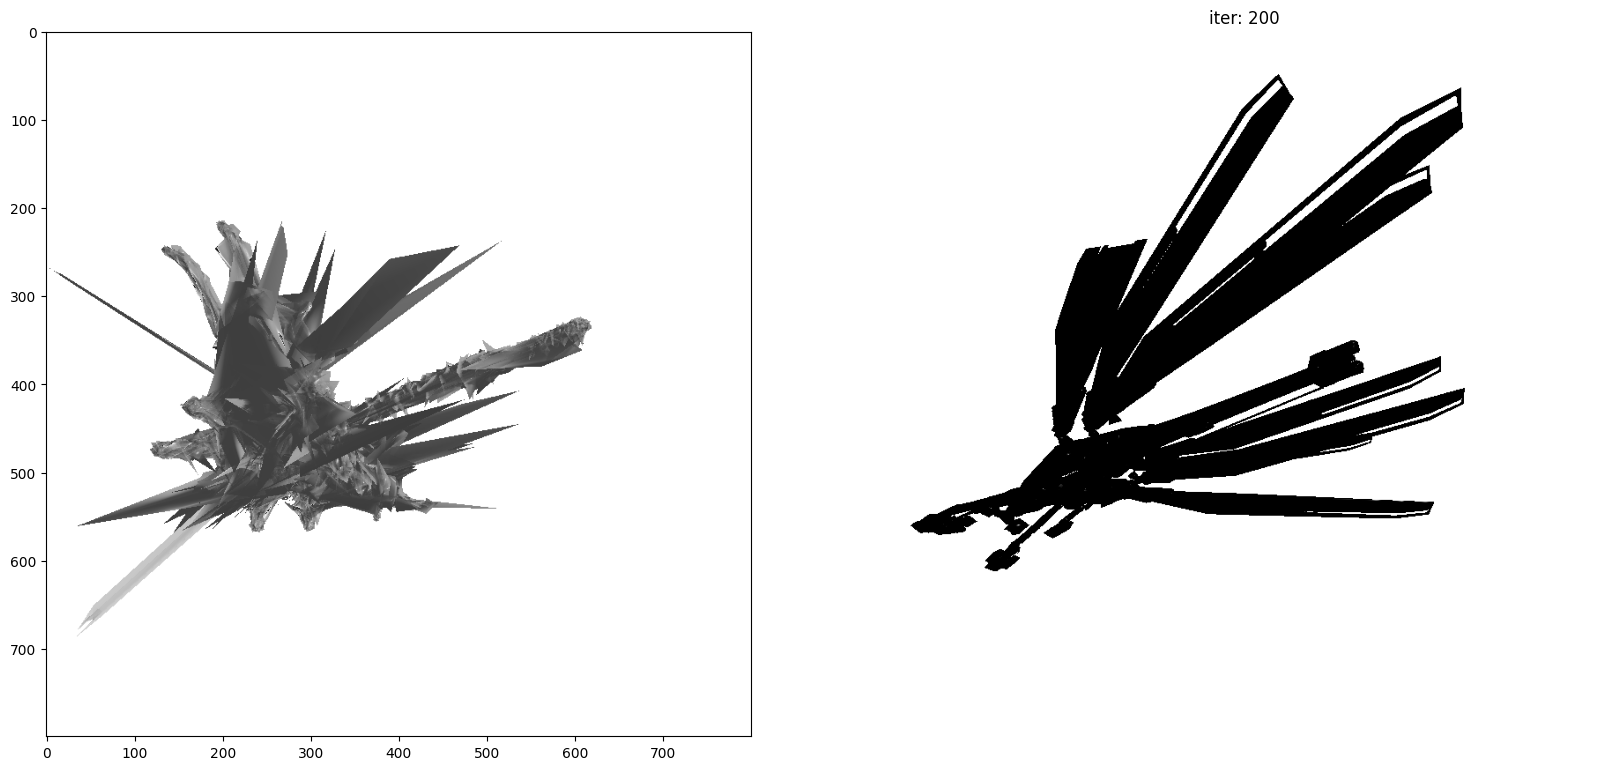

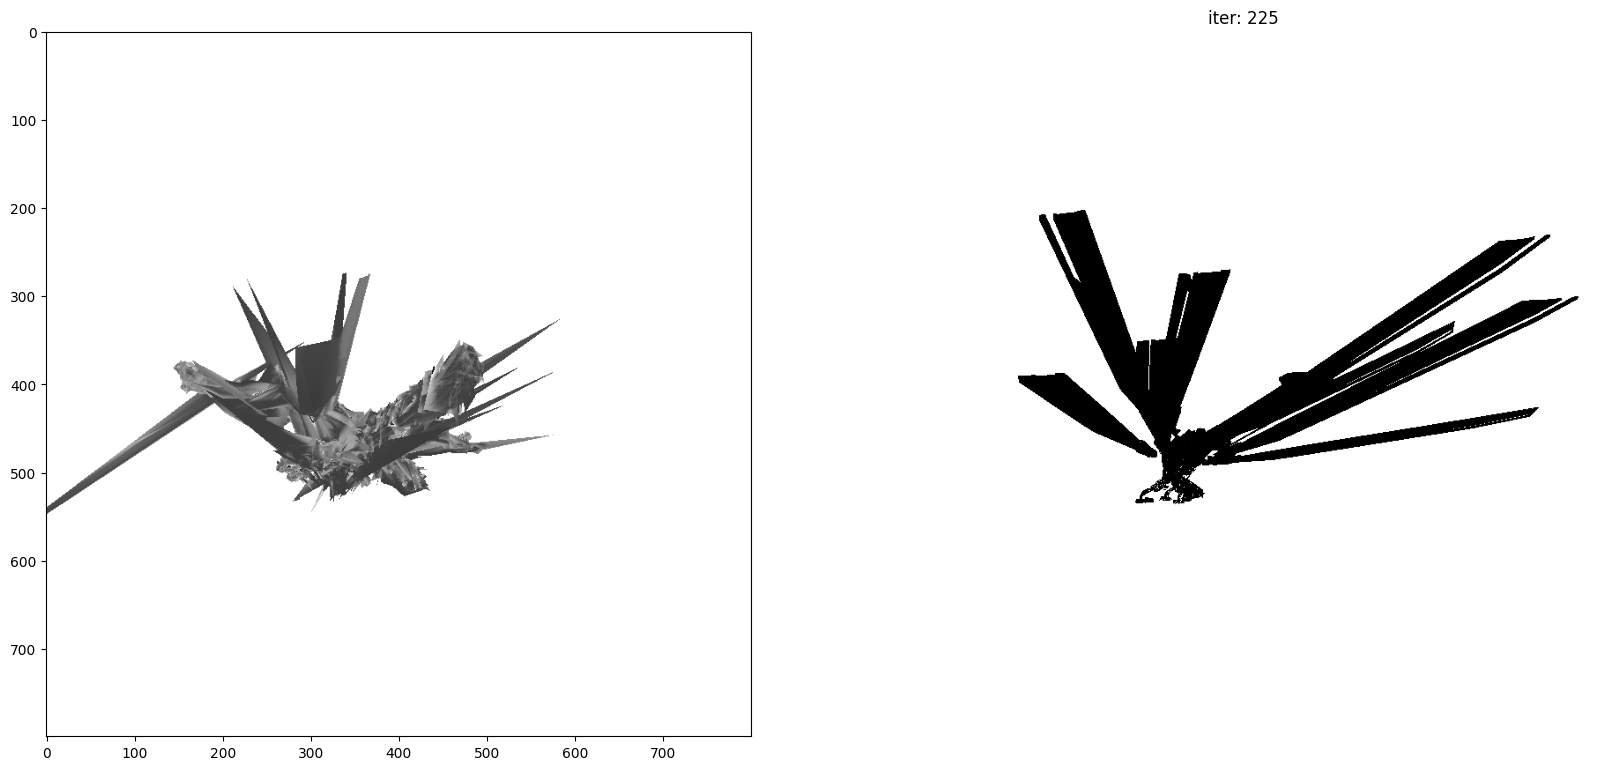

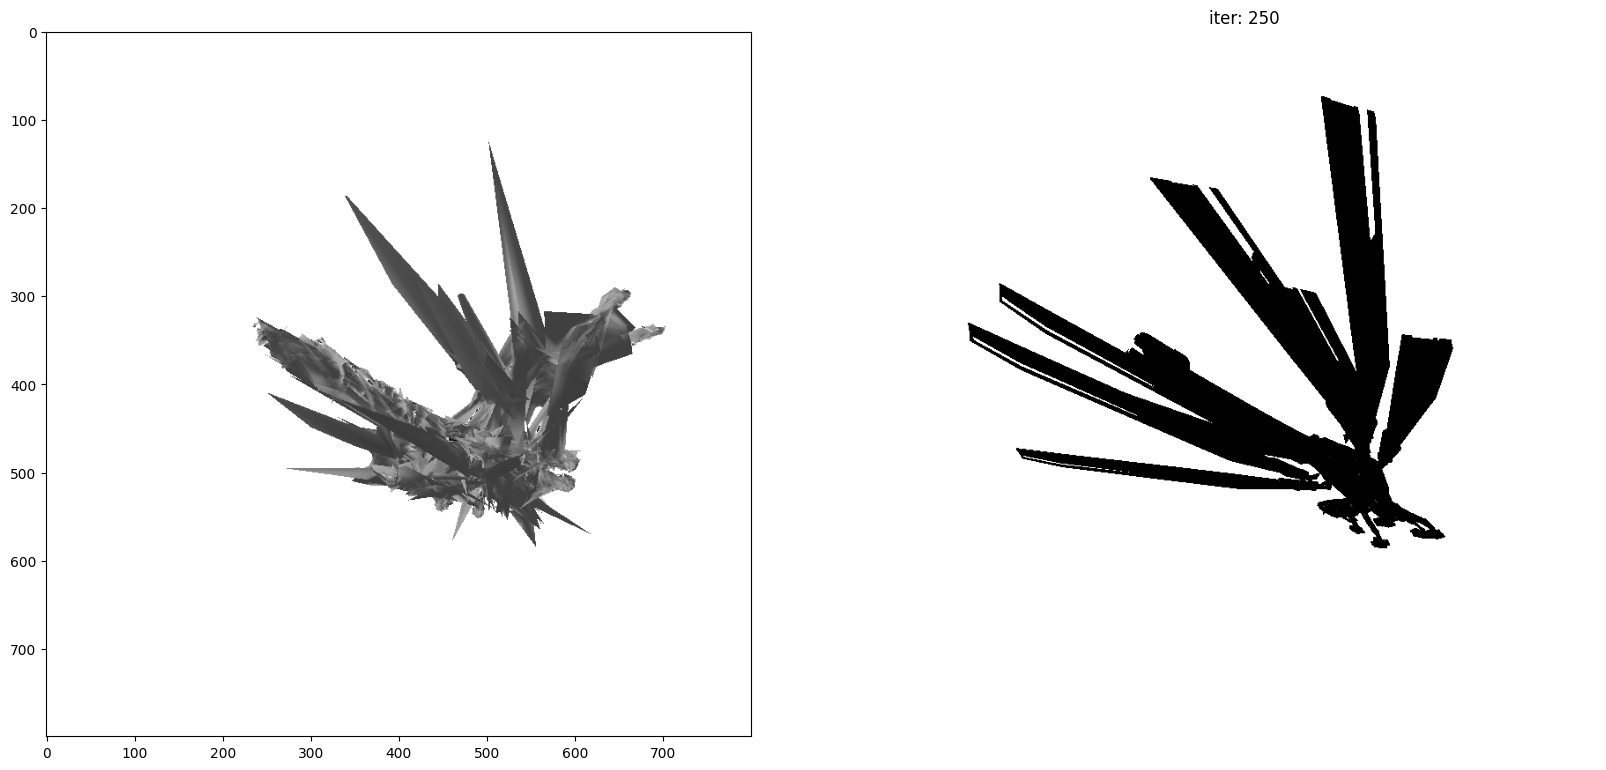

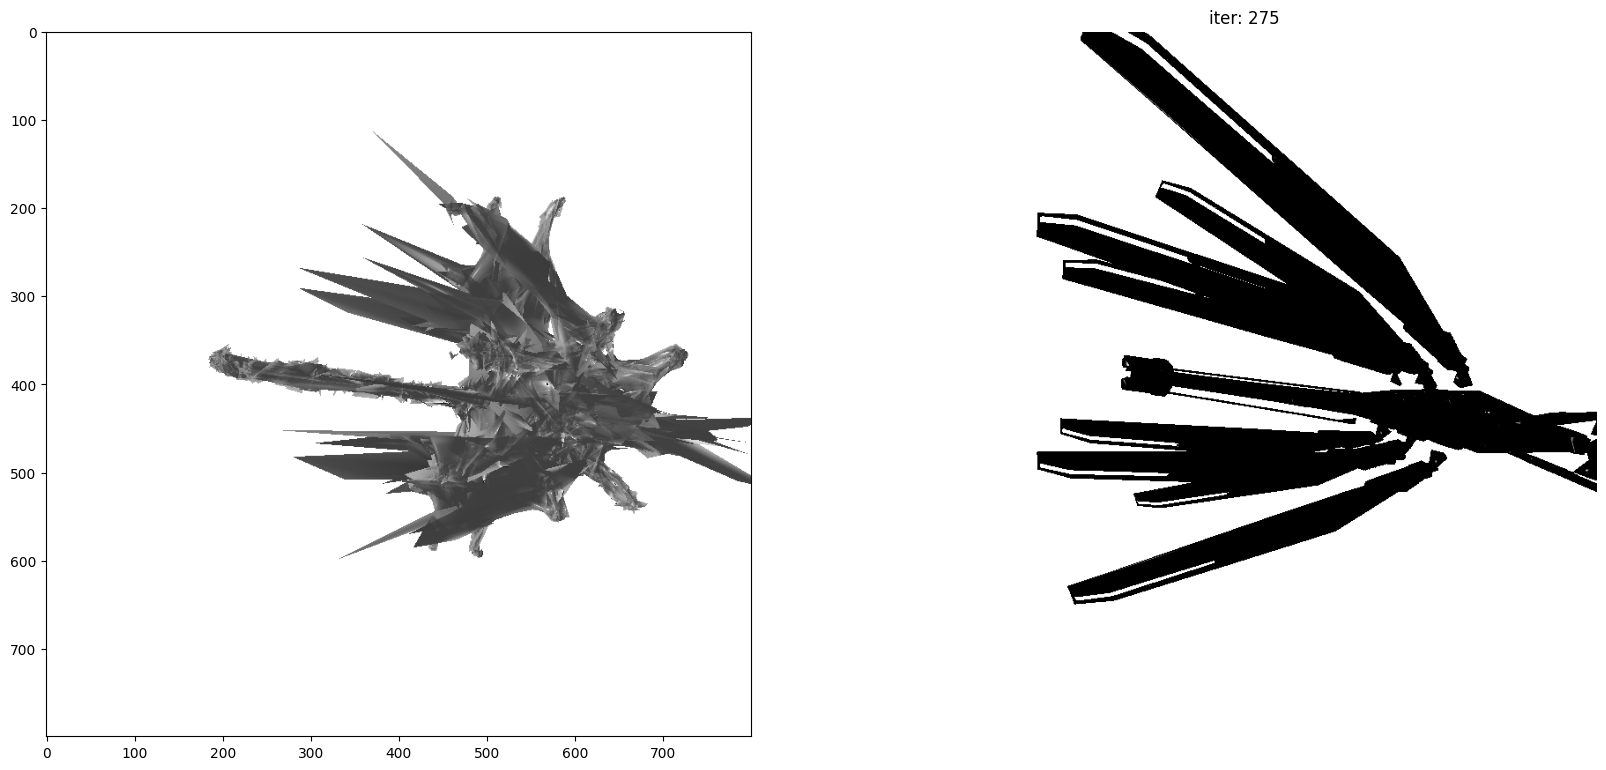

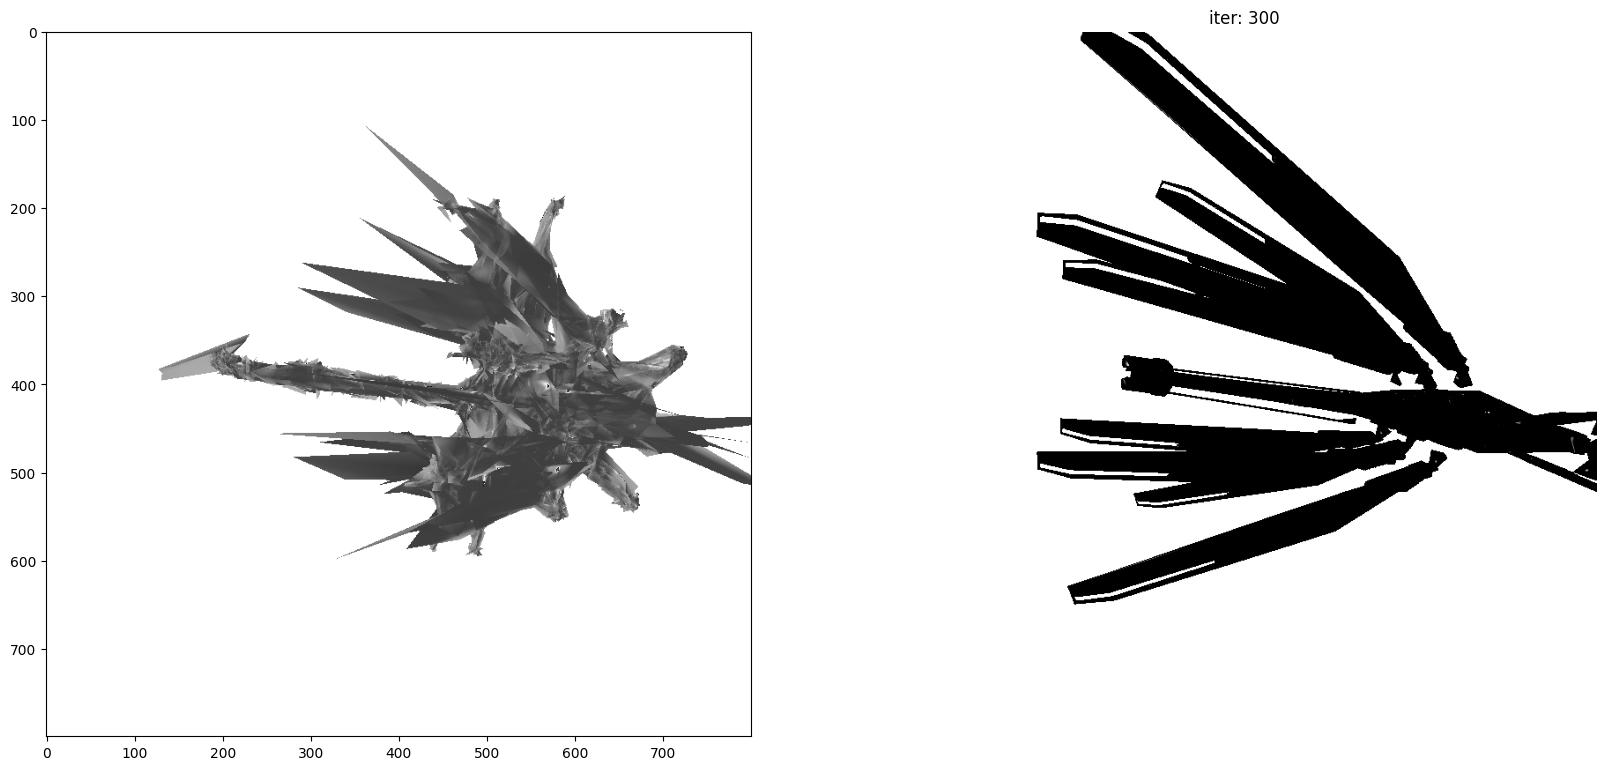

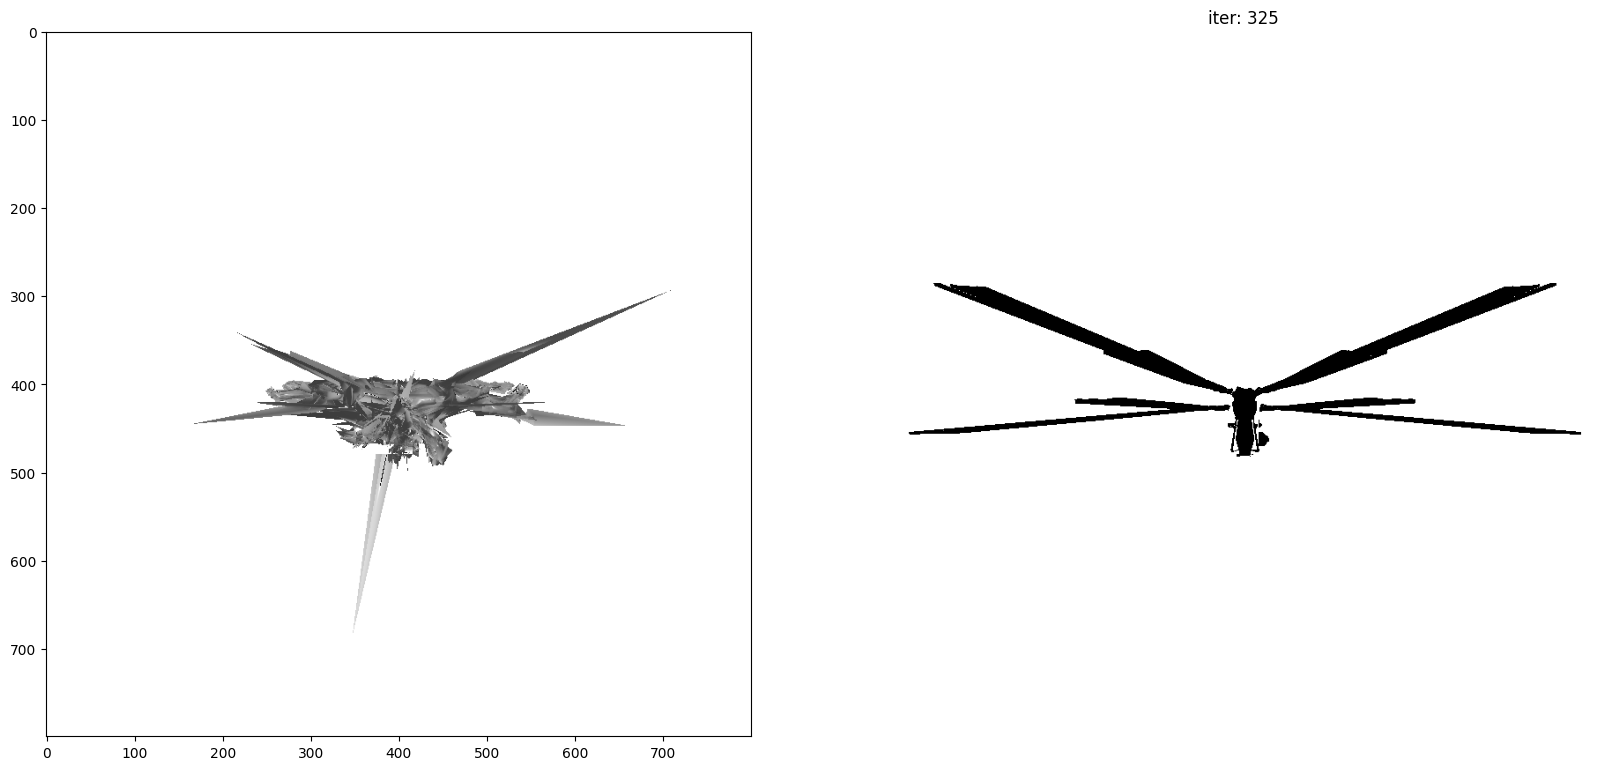

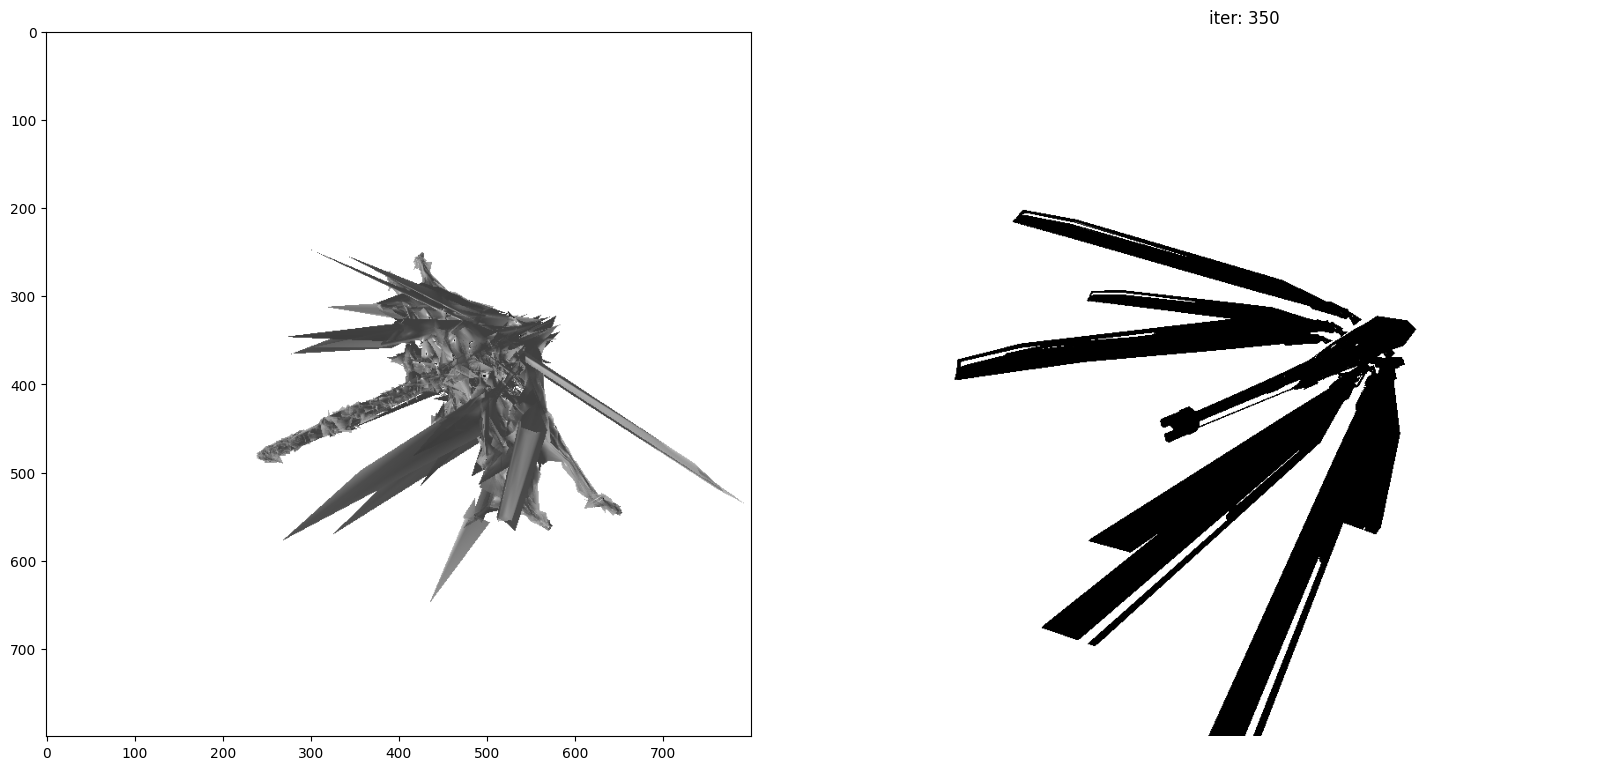

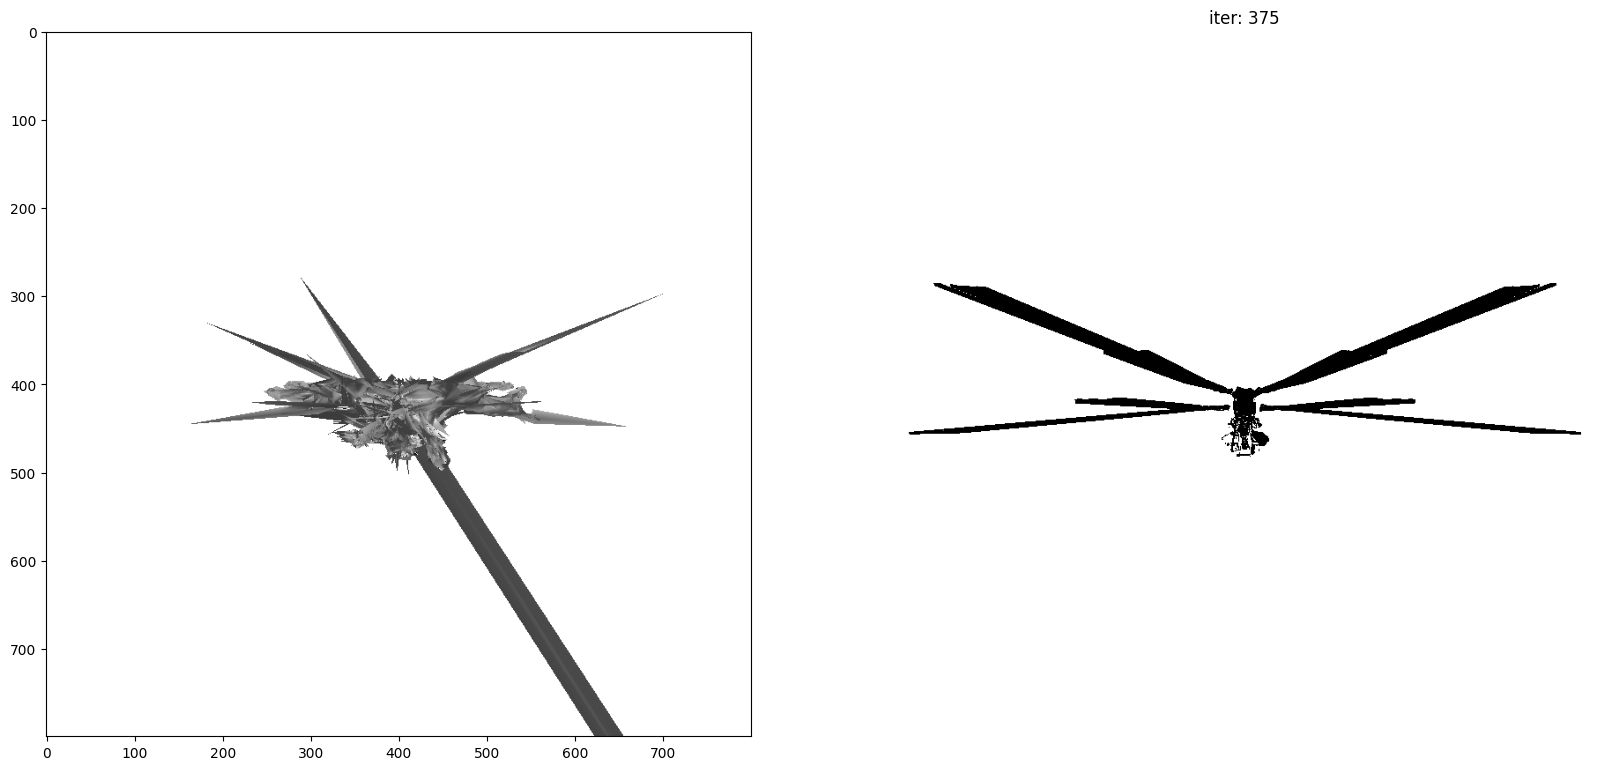

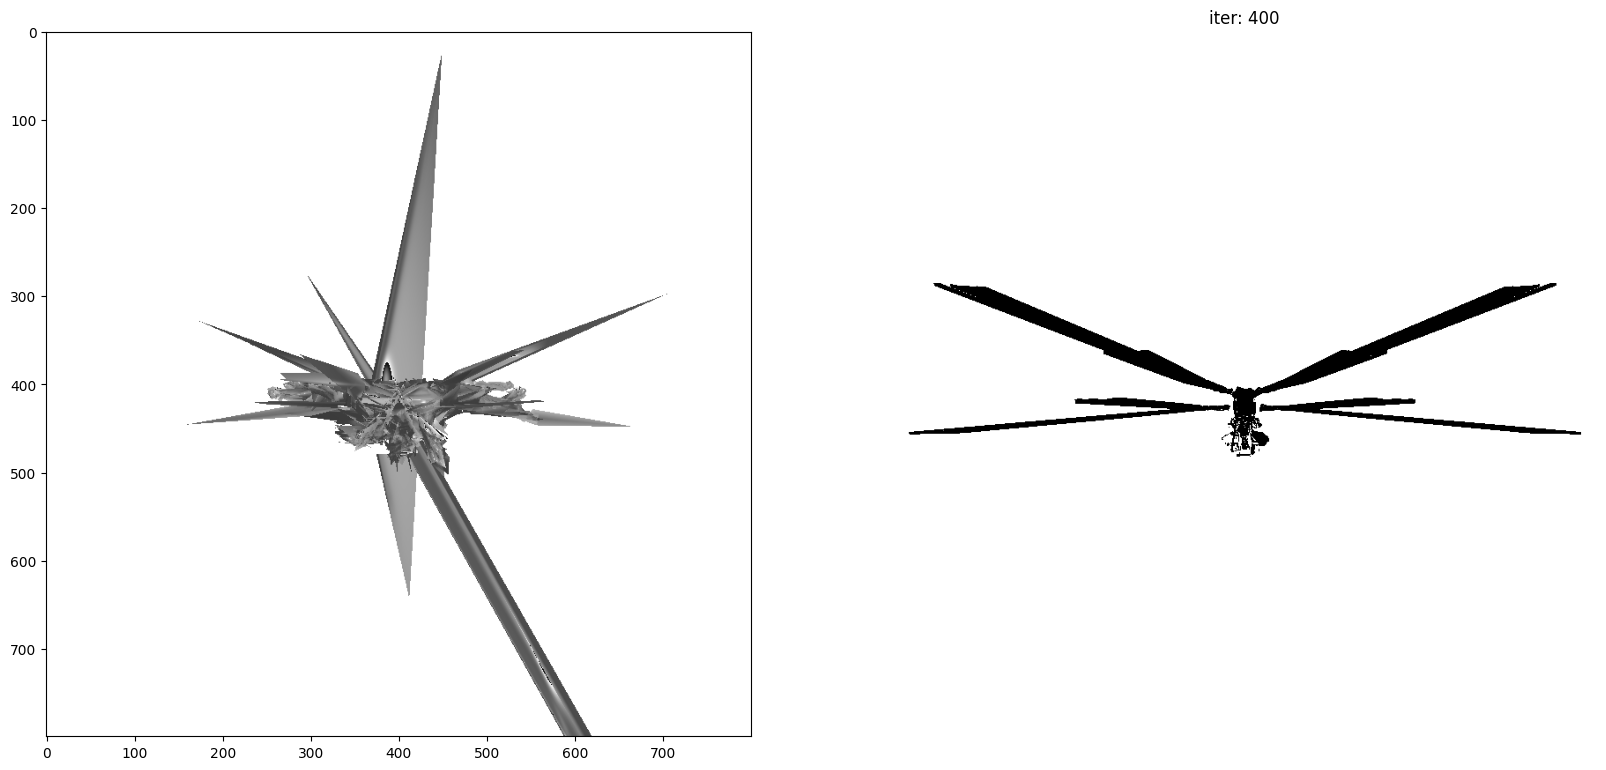

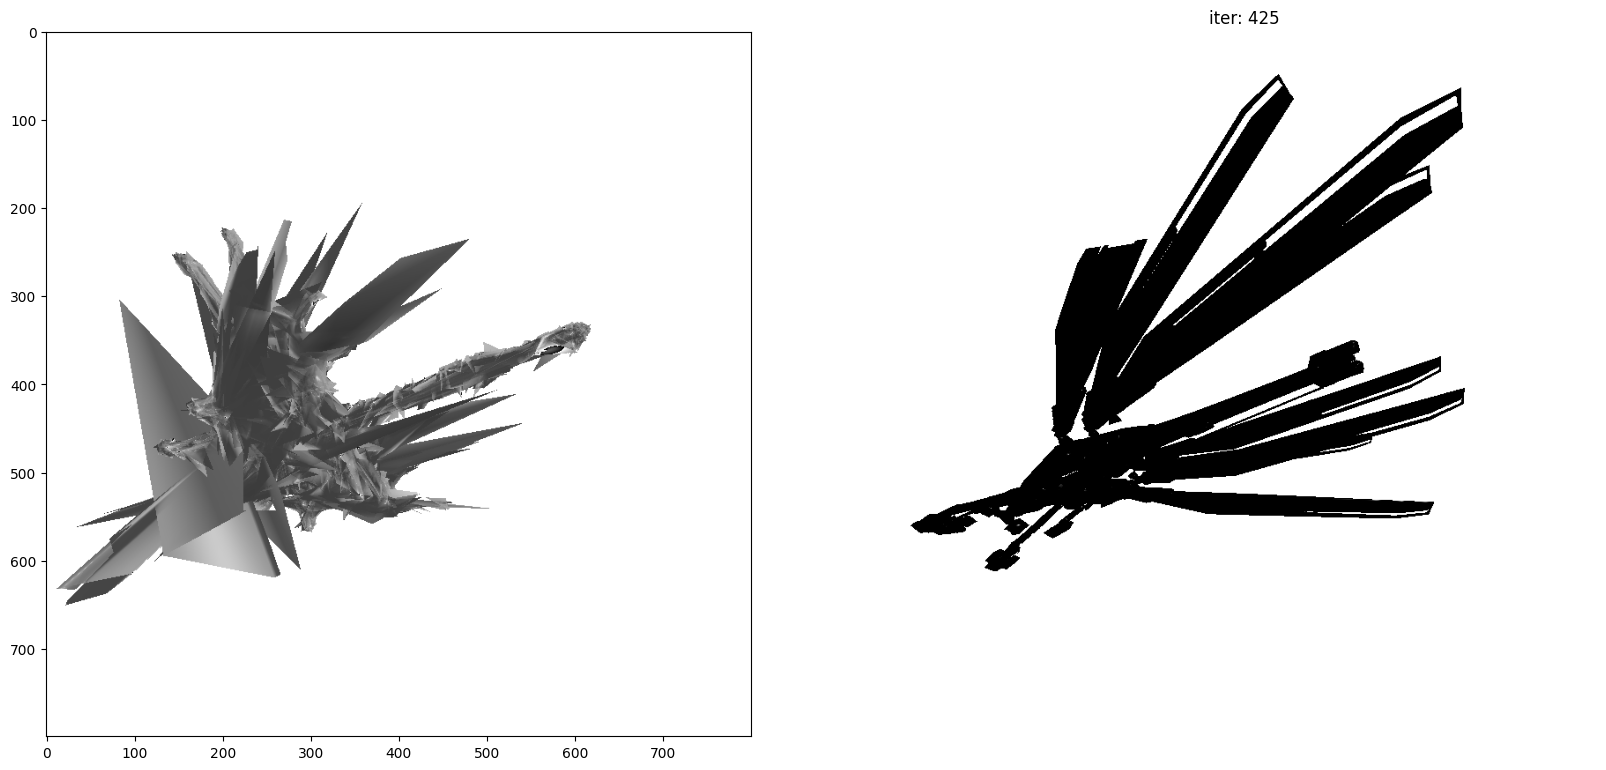

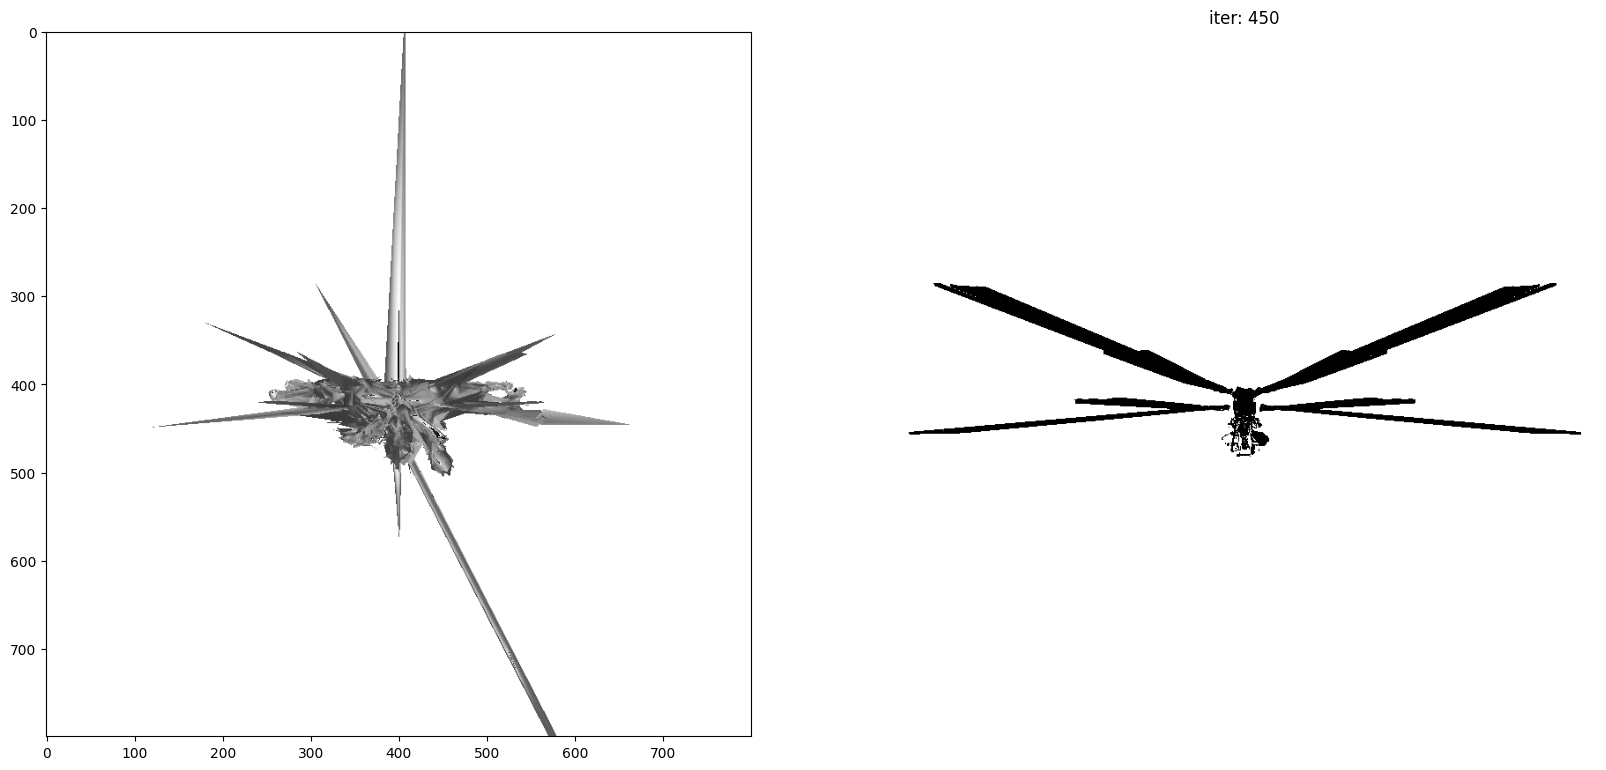

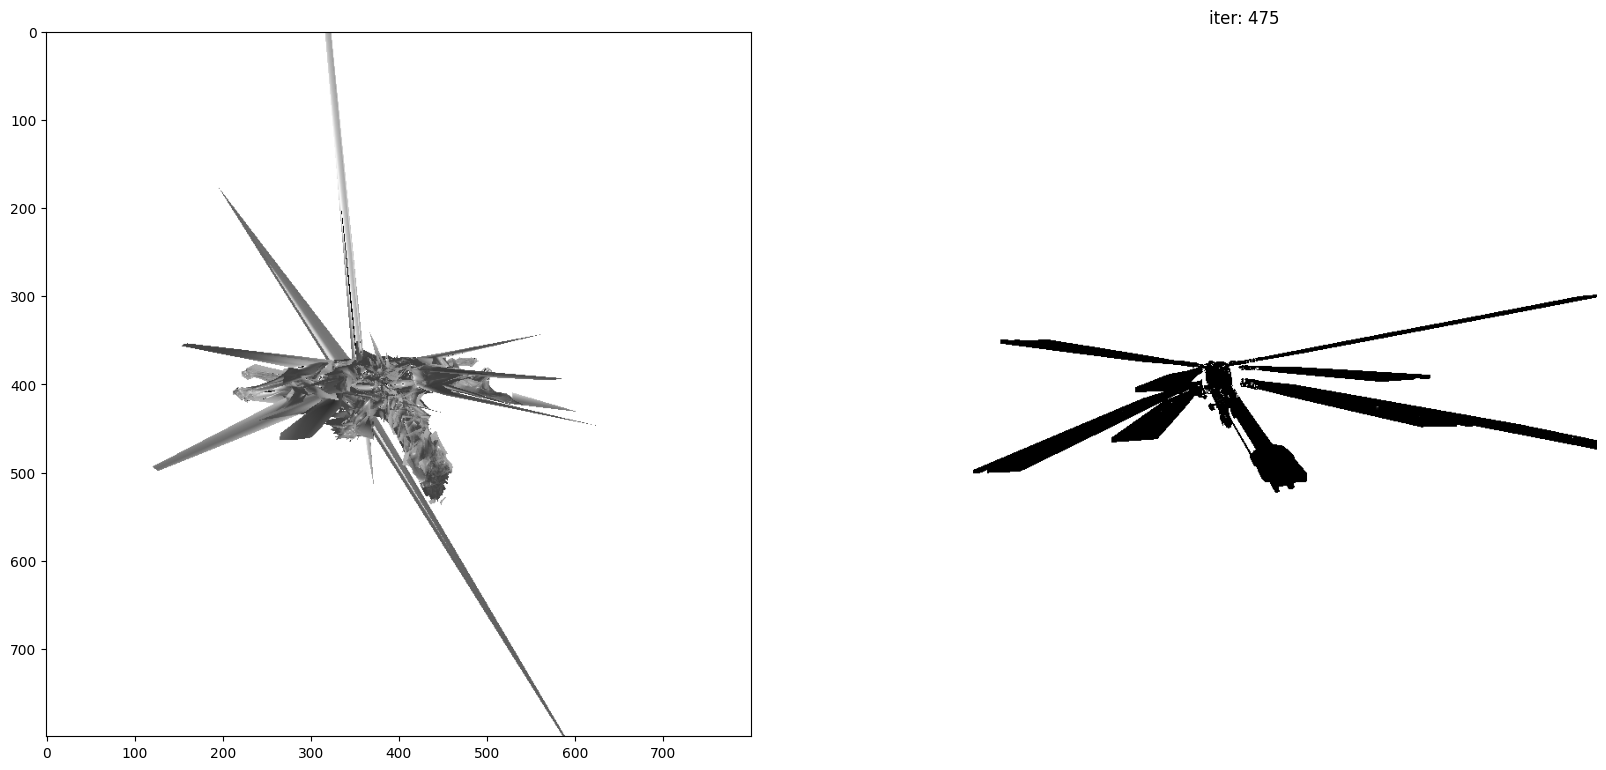

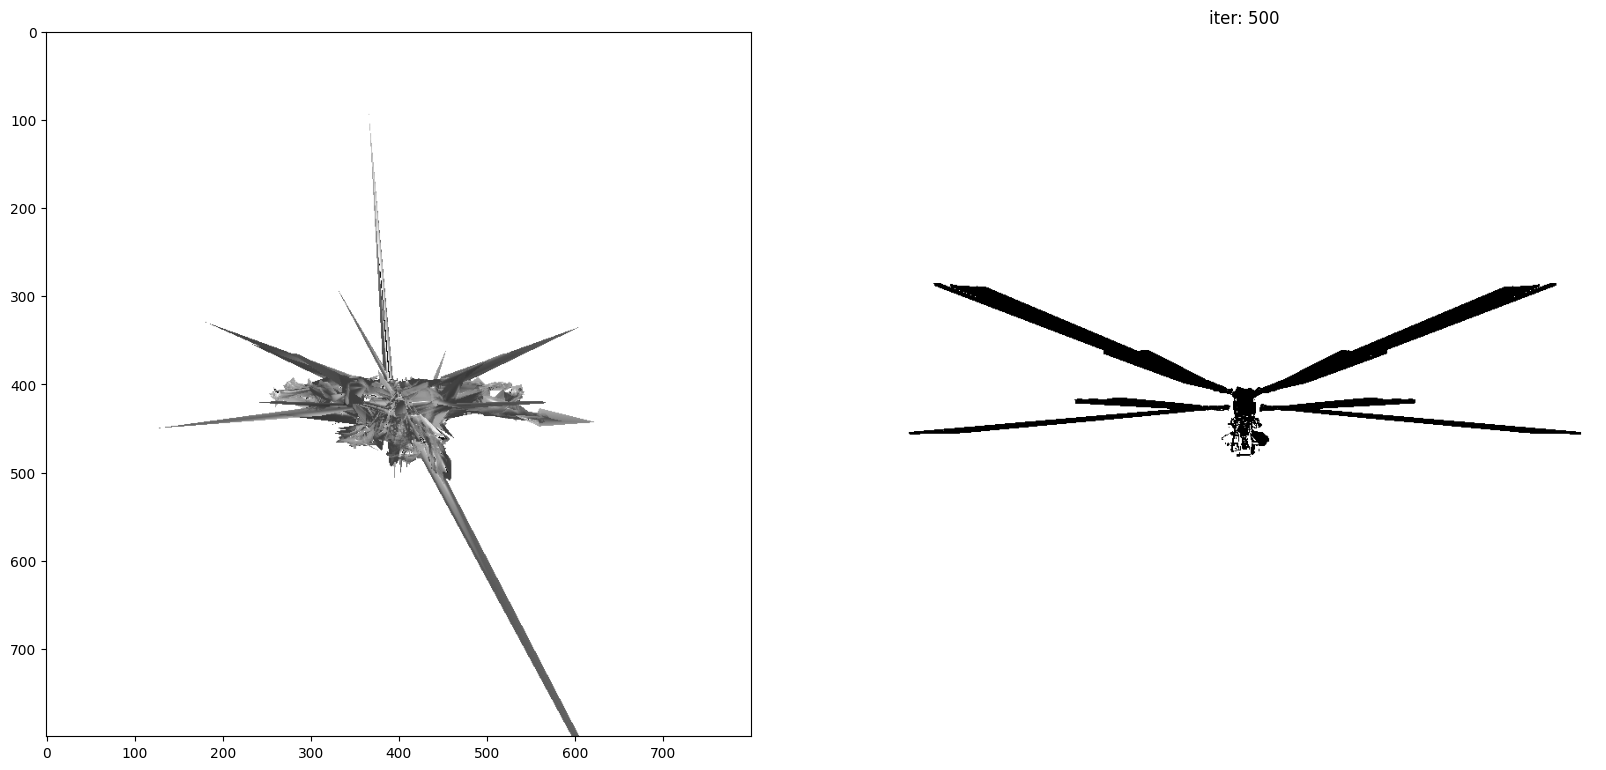

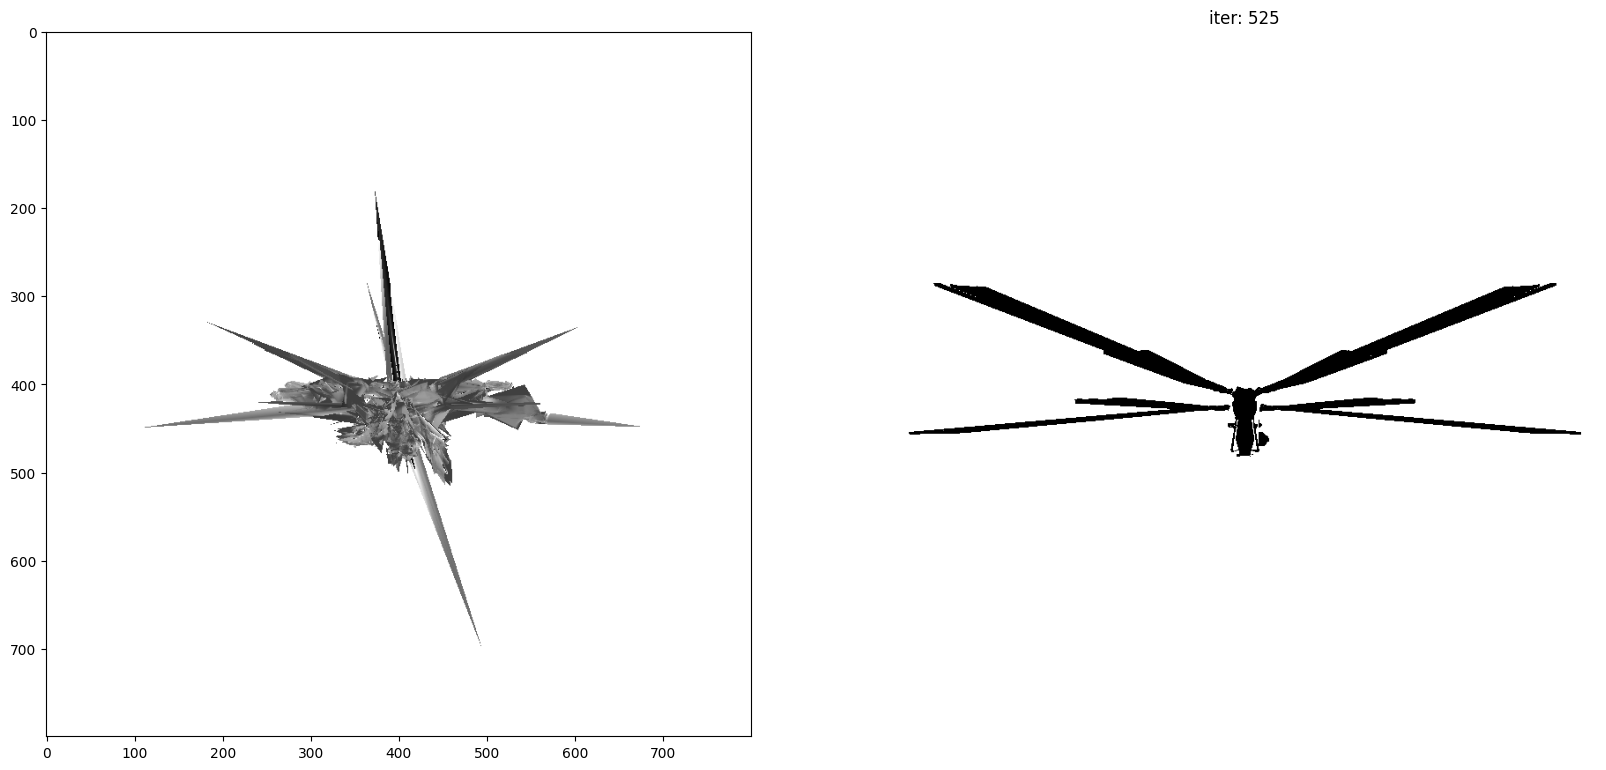

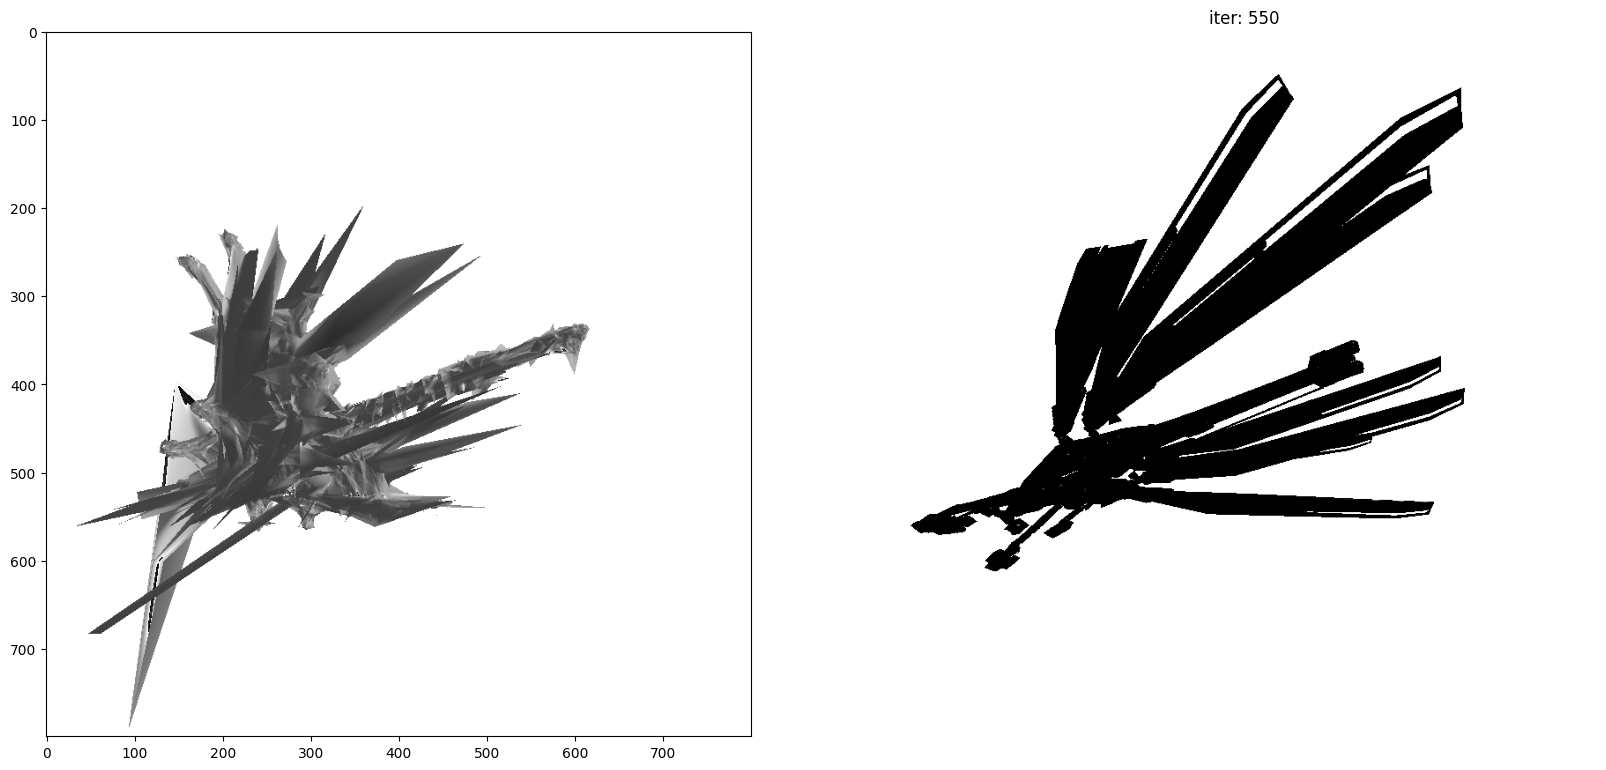

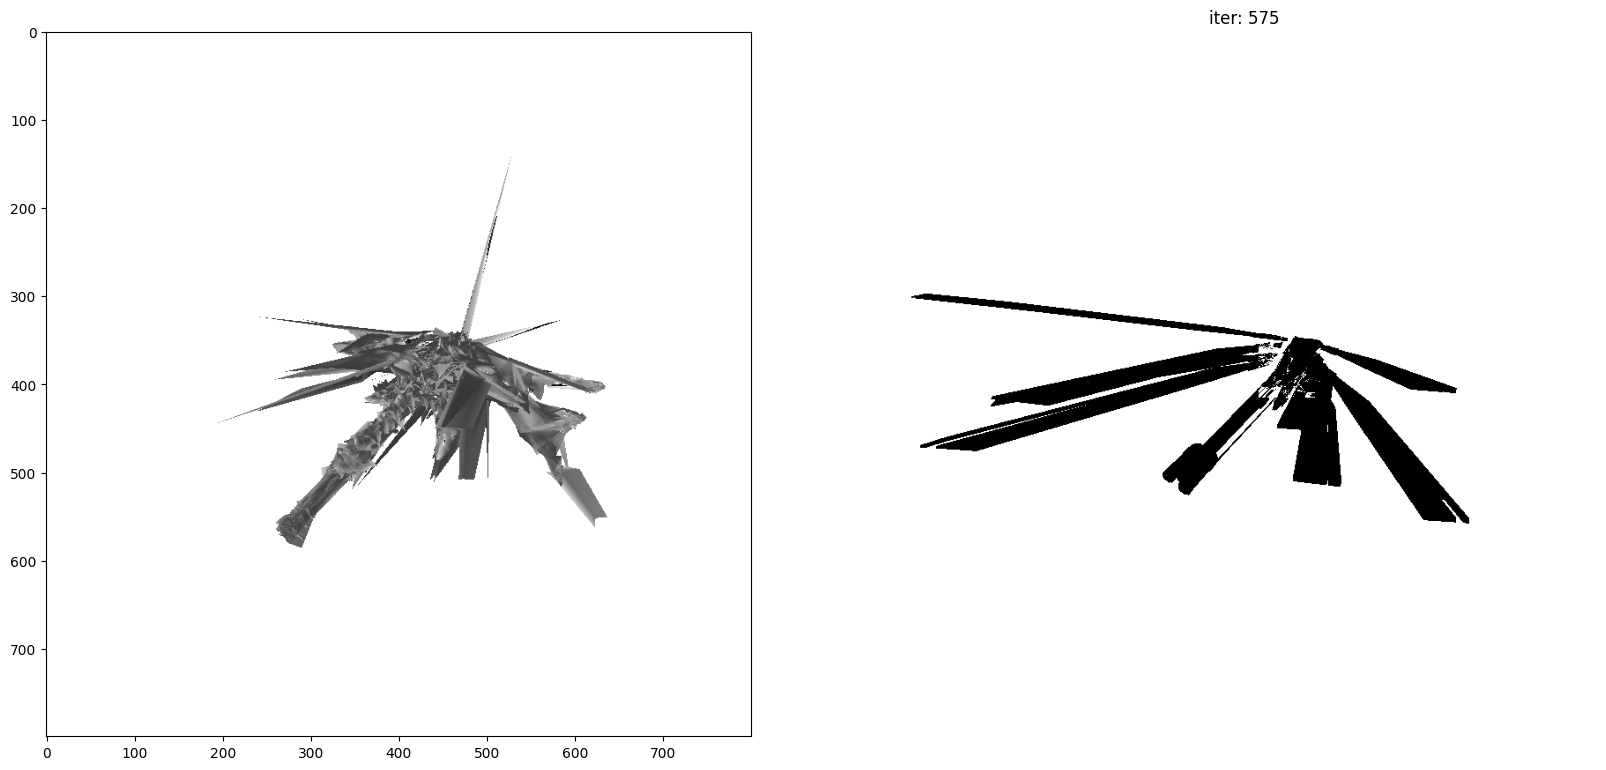

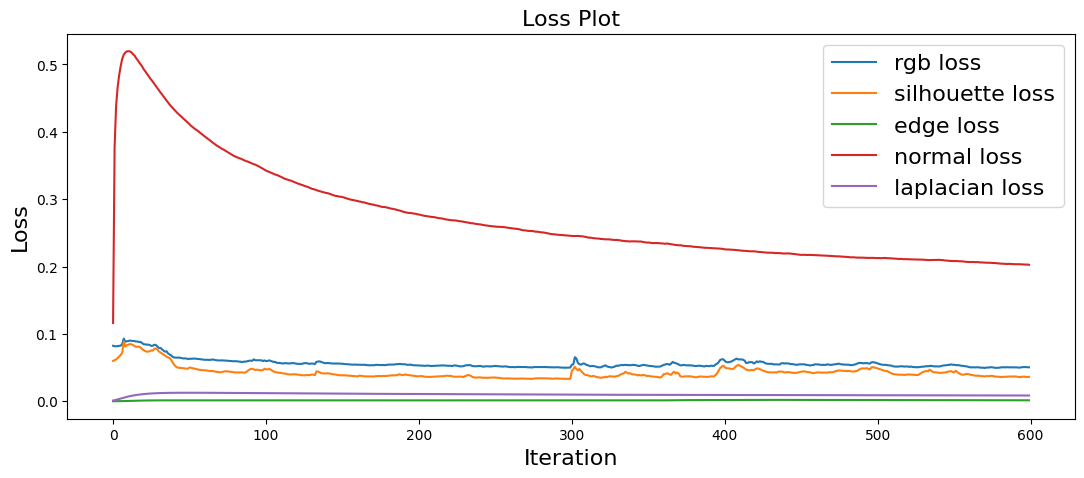

In [ ]:
pred_mesh = train(
                  num_epochs = num_epochs,
                  num_views = NUM_VIEWS,
                  num_views_per_batch = num_views_per_batch,
                  mesh_loss_fn= torch.nn.MSELoss(),
                  optimizer = optimizer,
                  # src mesh data
                  src_mesh = subdivided_src_mesh,
                  src_verts_rgb = src_verts_rgb,
                  deform_verts = src_deform_verts,
                  # target mesh data
                  target_silhouette = target_sil,
                  target_verts_rgb = target_rgb,
                  # rendering variables
                  diff_renderer = diff_renderer,
                  cameras = cameras,
                  plot_interval=25,
              )

### Iteration 2 Results

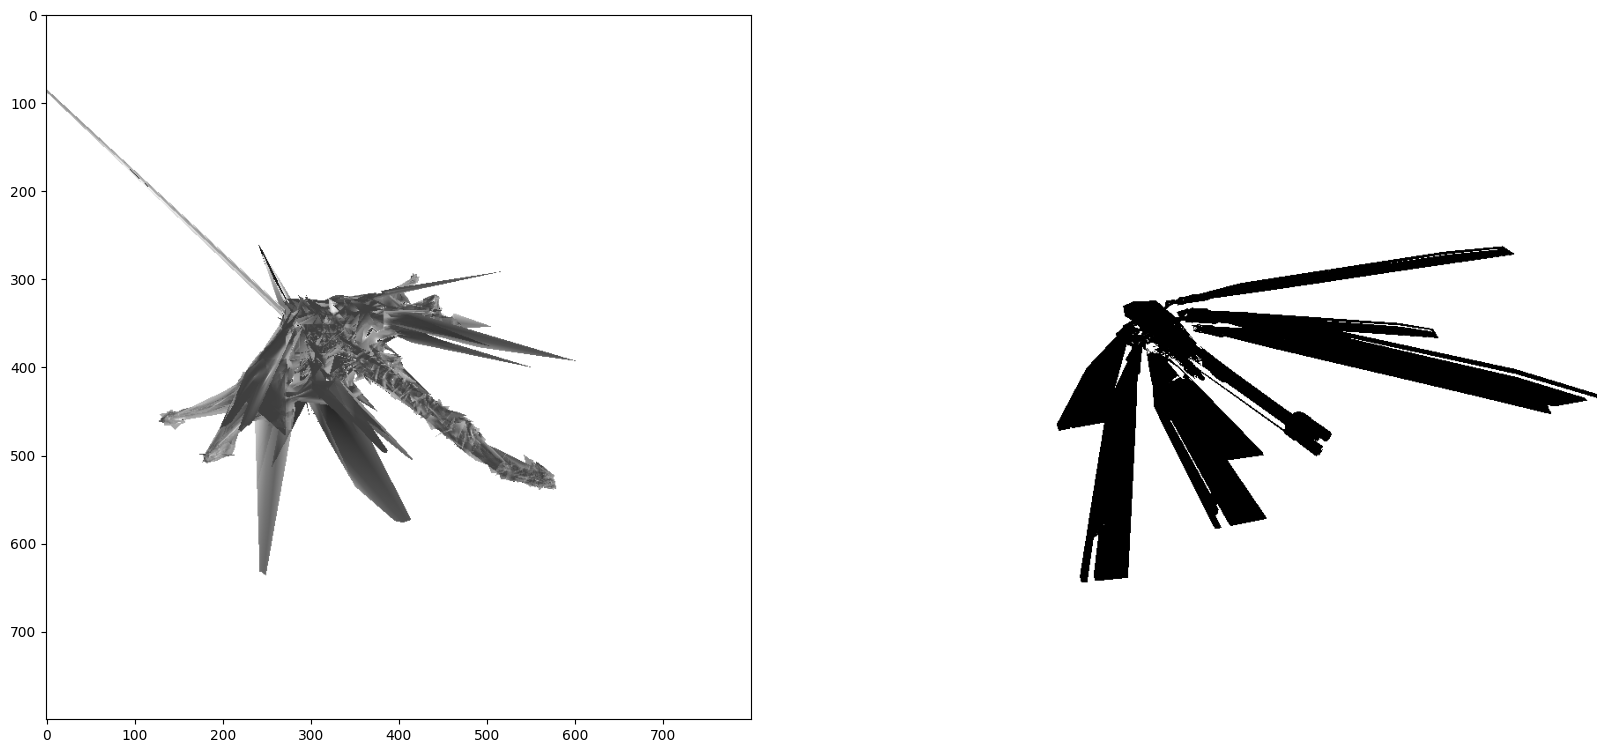

In [ ]:
display_prediction(pred_mesh,
                   vis_renderer,
                   cameras = cameras,
                   test_idx=TEST_IDX,
                   target_image=target_rgb[TEST_IDX], silhouette=False)